In [2]:
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from scipy import stats
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
%matplotlib inline

In [2]:
params = None
epsilon = 1.0
min_epsilon = 0.01
decay_rate = 1.0

In [3]:
class Hypothesis:
    def __init__(self, value, is_active=True, decision_region=None):
        self.value = value
        self.is_active = is_active
        self.decision_region = decision_region


In [4]:
def binary(num, length):
    '''
        creates a name for each hypotheses
    '''
    return format(num, '#0{}b'.format(length + 2))[2:]
def compute_initial_h_probs(theta, priors, hypothses):
    '''
    return a dictionary containing probabilities of each hypothesis (p(h)) with h's as keys
    parameters:
        theta: the condictional probabilites. m*n ndarray where m is the number of decision regions and n is the number of features
        priors: prior probabilities of decision regions (ys)
        hypothses: ndarray containing all hypotheses (objects) 
    '''
    probs = {}
    for h in hypothses:
        p_h_y = 1
        for feature, value in enumerate(h.value):
            if int(value)==1:
                p_h_y = p_h_y * theta[:,feature] 
            else:
                p_h_y = p_h_y * (1-theta[:,feature])
        
        p_h = sum(priors*p_h_y)
        probs[h.value] = p_h
    return probs
    
    
def find_inconsistent_hypotheses(feature, hypotheses, feature_value):
    #checked
    '''
    returns a list of hypothesis inconsistent with feature observation (feature values)
    parameters:
        feature: the observed feature
        hypotheses: the list of hypotheses (objects)
        feature_value: observed feature value
    '''
    inconsistent_hypotheses = []
    for h in hypotheses:
        if str(h.value)[int(feature)] != str(feature_value):
            inconsistent_hypotheses.append(h)
#     print([h.value for h in inconsistent_hypotheses])
    return inconsistent_hypotheses

def calculate_p_y_xA(theta, priors, observations):
    #checked
    '''
    returns a ndarray containing p(y|x_A) for all ys
    parameters:
        theta: the condictional probabilites. m*n ndarray where m is the number of decision regions and n is the number of features
        priors: prior probabilities of decision regions (ys)
        observations: a dictionary containing queried features and respective values 
    '''
    if (len(observations.items())==0):
        return priors
    #calculate p_xA
    p_xA_y = 1
    for feature, value in observations.items():
        if int(value)==1:
            p_xA_y = p_xA_y * theta[:,int(feature)] 
        else:
            p_xA_y = p_xA_y * (1-theta[:,int(feature)])
            
    
    p_xA = sum(priors*p_xA_y)
    p_y_xA = p_xA_y*priors/p_xA
    
#     print(p_y_xA)
    return p_y_xA
            
    
    
    
def calculate_p_feature_xA(feature, theta, p_y_xA, feature_value):
    #checked
    '''
    parameters:
        theta: the condictional probabilites. m*n ndarray where m is the number of decision regions and n is the number of features
        priors: prior probabilities of decision regions (ys)
        feature_value: value of the feature. 1 or 0
    '''
    if feature_value == 1:
        p_x_y = theta[:, int(feature)]    
    else:
        p_x_y = 1 - theta[:,int(feature)]
        
    p_feature_xA = sum(p_x_y*p_y_xA)
    
#     print(p_feature_xA)
    return p_feature_xA
        


def calculate_expected_cut(feature,p_feature_xA, p_not_feature_xA, G, hypotheses):
    #checked
    #Need a proper way to find respective hypothesis
    '''
    parameters:
        hypotheses: the list of hypotheses (objects)
        p_feature_xA: P(x=1|x_A)
        p_not_feature_xA: P(x=0|x_A)
        G: the graph of hypotheses
    '''
    
    #step1: find the hypotheses inconsistent with feature
    hypotheses_feature = find_inconsistent_hypotheses(feature, hypotheses, 1)
    
    #step2: find the hypotheses inconsistent with not feature
    hypotheses_not_feature = find_inconsistent_hypotheses(feature, hypotheses, 0)
    
    #step3: Calculate the weights for each case
#     print(G.edges(data=True))
    edges_feature = G.edges(nbunch=[h.value for h in hypotheses_feature], data=True)
    sum_weights_feature = sum([w['weight'] for (u,v,w) in edges_feature])
    
    edges_not_feature = G.edges(nbunch=[h.value for h in hypotheses_not_feature], data=True)
    sum_weights_not_feature = sum([w['weight'] for (u,v,w) in edges_not_feature])
    
#     print(sum_weights_feature)
#     print(p_feature_xA)
#     print(sum_weights_not_feature)
#     print(p_not_feature_xA)
    
    #step4: Calculate the expectation
    expected_cut = p_feature_xA * sum_weights_feature + p_not_feature_xA *sum_weights_not_feature
#     print(expected_cut)
    return expected_cut





In [5]:
def EC2(h_probs, document, hypotheses, decision_regions, theta, priors, observations, G=None, epsilon=0.0):
    '''
    Return the next feature to be queried and the current graph
    Parameters:
        G: the graph
        h_probs: a dictionary containing h_indices as keys and p(h|x_A) as values
        document: a dictionary containing feature names as keys and features as values
        hypotheses: ndarray of Hypothesis objects
        decision_regions: two dimentional list. first dimension is decision region and the second is the list of hyptheses in that region
        theta: the condictional probabilites. m*n ndarray where m is the number of decision regions and n is the number of features
        priors: prior probabilities of decision regions (ys)
        observations: a dictionary containing queried features and respective values 
    note: hypothesis names are the respective decimal number of the binary realization
    '''
    #building the graph if it is none
    if G is None:
        G = nx.Graph()
        for i in range(len(hypotheses)):
            for j in range(i+1, len(hypotheses)):
                if hypotheses[i].decision_region != hypotheses[j].decision_region:
                    G.add_edge(hypotheses[i].value, hypotheses[j].value, weight=h_probs[hypotheses[i].value]*h_probs[hypotheses[j].value])
                    
                
        
#         for counter, region in enumerate(decision_regions):
#             nodes_to_connect = sum(decision_regions[counter+1:], [])
#             #connect nodes
#             for node1 in region:
#                 for node2 in nodes_to_connect:
#                     G.add_edge(node1, node2, weight=h_probs[node1]*h_probs[node2])
                
    #select the feature
    best_feature = None
    max_cut = float('-inf')
    rand_number = random.uniform(0,1)
    if rand_number < epsilon:
        return np.random.choice(list(document.keys())), G
    for feature in document.keys(): 
#         print(feature)
        p_y_xA = calculate_p_y_xA(theta, priors, observations)
        p_feature_xA =  calculate_p_feature_xA(feature, theta, p_y_xA, 1)#P(x=1|x_A)
        p_not_feature_xA =  calculate_p_feature_xA(feature, theta, p_y_xA, 0)#P(x=0|x_A)
        expected_cut = calculate_expected_cut(feature, p_feature_xA, p_not_feature_xA, G, hypotheses)
        if (expected_cut > max_cut):
            max_cut = expected_cut
            best_feature = feature
    return best_feature, G

In [6]:
def IG(theta, priors, observations, document, epsilon=0.0):
    #step1: compute entropy(y|x_A)
    p_y_xA = calculate_p_y_xA(theta, priors, observations)
    temp = p_y_xA * np.log2(p_y_xA)
    entropy_y_xA = -sum(temp)
    
    
    #step2: for all features x compute IG(x)
    best_feature = None
    max_IG = float('-inf')
    rand_number = random.uniform(0,1)
    if rand_number <= epsilon:
        return np.random.choice(list(document.keys()))
    for feature in document.keys():
        #a. compute entropy(y|x_A,feature=1)
        new_observations = {feature:1}
        new_observations.update(observations)
        p_y_xA_feature = calculate_p_y_xA(theta, priors, new_observations)
        temp = p_y_xA_feature * np.log2(p_y_xA_feature)
        entropy_y_xA_feature = -sum(temp)
        #b. compute entropy(y|x_A,feature=0)
        new_observations = {feature:0}
        new_observations.update(observations)
        p_y_xA_not_feature = calculate_p_y_xA(theta, priors, new_observations)
        temp = p_y_xA_not_feature * np.log2(p_y_xA_not_feature)
        entropy_y_xA_not_feature = -sum(temp)
        #c. compute expected IG(feature)
        p_feature_xA =  calculate_p_feature_xA(feature, theta, p_y_xA, 1)#P(x=1|x_A)
        p_not_feature_xA =  calculate_p_feature_xA(feature, theta, p_y_xA, 0)#P(x=0|x_A)
        
        expected_IG = p_feature_xA*(entropy_y_xA-entropy_y_xA_feature)+p_not_feature_xA*(entropy_y_xA-entropy_y_xA_not_feature)
        if (expected_IG > max_IG):
            max_IG = expected_IG
            best_feature = feature
    return best_feature

In [7]:
def US(theta, priors, observations, document, h_probs, hypothses):
    #step1: compute entropy(H|x_A)
    p_h_xA = np.array(list(h_probs.values()))
    temp = p_h_xA * np.log2(p_h_xA)
    entropy_h_xA = -sum(temp)
    
    #step2: for all features x compute US(x)
    best_feature = None
    max_US = float('-inf')
    for feature in document.keys():
        #a. compute entropy(h|x_A, feature=1)
        new_observations = {feature:1}
        new_observations.update(observations)
        h_probs = {}
        p_y_xA = calculate_p_y_xA(theta, priors, new_observations)
        for h in hypothses:
            p_h_y = 1
            for feature_v, value in enumerate(h.value):
                if int(value)==1:
                    p_h_y = p_h_y * theta[:,feature_v] 
                else:
                    p_h_y = p_h_y * (1-theta[:,feature_v])

            p_xA_y = 1
            for feature_v, value in new_observations.items():
                if int(value)==1:
                    p_xA_y = p_xA_y * theta[:,int(feature_v)] 
                else:
                    p_xA_y = p_xA_y * (1-theta[:,int(feature_v)])

            p_h_xA_y = p_h_y/p_xA_y

            p_xA = sum(priors*p_xA_y)
            p_y_xA = p_xA_y*priors/p_xA

            p_h_xA = sum(p_y_xA*p_h_xA_y)
            h_probs[h.value] = p_h_xA
            
        p_h_xA_feature = np.array(list(h_probs.values()))
        temp = p_h_xA_feature * np.log2(p_h_xA_feature)
        entropy_h_xA_feature = -sum(temp)
        
        
        #a. compute entropy(h|x_A, feature=0)
        new_observations = {feature:0}
        new_observations.update(observations)
        h_probs = {}
        p_y_xA = calculate_p_y_xA(theta, priors, new_observations)
        for h in hypothses:
            p_h_y = 1
            for feature_v, value in enumerate(h.value):
                if int(value)==1:
                    p_h_y = p_h_y * theta[:,feature_v] 
                else:
                    p_h_y = p_h_y * (1-theta[:,feature_v])

            p_xA_y = 1
            for feature_v, value in new_observations.items():
                if int(value)==1:
                    p_xA_y = p_xA_y * theta[:,int(feature_v)] 
                else:
                    p_xA_y = p_xA_y * (1-theta[:,int(feature_v)])

            p_h_xA_y = p_h_y/p_xA_y

            p_xA = sum(priors*p_xA_y)
            p_y_xA = p_xA_y*priors/p_xA

            p_h_xA = sum(p_y_xA*p_h_xA_y)
            h_probs[h.value] = p_h_xA
        p_h_xA_not_feature = np.array(list(h_probs.values()))
        temp = p_h_xA_not_feature * np.log2(p_h_xA_not_feature)
        entropy_h_xA_not_feature = -sum(temp)
        
        
        
        #c. compute expected US(feature)
        p_y_xA = calculate_p_y_xA(theta, priors, observations)
        p_feature_xA =  calculate_p_feature_xA(feature, theta, p_y_xA, 1)#P(x=1|x_A)
        p_not_feature_xA =  calculate_p_feature_xA(feature, theta, p_y_xA, 0)#P(x=0|x_A)
        
        expected_US = p_feature_xA*(entropy_h_xA-entropy_h_xA_feature)+p_not_feature_xA*(entropy_h_xA-entropy_h_xA_not_feature)
        if expected_US > max_US:
            max_US = expected_US
            best_feature = feature
            
    return best_feature
        
    

In [8]:
def decision_tree_learning(document, theta, max_steps, priors, hypothses, decision_regions, criterion): 
    '''
    Receives a document and builds a decision tree with the EC2 algorithm.
    Parameters:
        criterion: the method to choose next feature to be queried
        document: the document to be classified. A dictionary containing feature names as keys and features as values
        theta: the condictional probabilites. m*n ndarray where m is the number of decision regions and n is the number of features
        max_steps: the maximum number of features to be queried
        priors: prior probabilities of decision regions (ys)
        hypothses: ndarray of Hypothesis objects
        decision regions
    '''
    
    num_features = len(document.keys())
#     hypothses = []
#     for h in range(2**num_features):
#         new_h = Hypothesis(binary(h,num_features))
#         hypothses.append(new_h)
#     hypothses = np.array(hypothses)
    h_probs = compute_initial_h_probs(theta, priors, hypothses) #using the naive bayes assumption and summing over all class labels
    observations = {}
    G = None
    document_label = document.pop('label', None)
#     print(document)
    for step in range(max_steps):
        if ('EC2' in criterion):
            if (criterion == "EC2_epsgreedy"):
                feature_to_be_queried, G = EC2(h_probs,document,hypothses,decision_regions, theta, priors, observations, G, epsilon)
            else:
                feature_to_be_queried, G = EC2(h_probs,document,hypothses,decision_regions, theta, priors, observations, G, 0.0)
    #         print(feature_to_be_queried)
            #query the next feature.
            feature_value = document[feature_to_be_queried]
            feature_value = int(float(feature_value))
            observations[feature_to_be_queried] = int(float(feature_value))
            
            #remove inconsistent hypotheses
            inconsistent_hypotheses = find_inconsistent_hypotheses(feature_to_be_queried, hypothses,feature_value)
            
#             print(observations)
#             print('inconsistent')
#             print([h.value for h in inconsistent_hypotheses])
#             print('before')
#             print([h.value for h in hypothses])
            for inconsistenthypo in inconsistent_hypotheses:
                hypothses = [h for h in hypothses if h.value!=inconsistenthypo.value]
#             print('after')
#             print([h.value for h in hypothses])
            
            #update p(h|x_A)
            h_probs = {}
            p_y_xA = calculate_p_y_xA(theta, priors, observations)
            for h in hypothses:
                p_h_y = 1
                for feature, value in enumerate(h.value):
                    if int(value)==1:
                        p_h_y = p_h_y * theta[:,feature] 
                    else:
                        p_h_y = p_h_y * (1-theta[:,feature])

                p_xA_y = 1
                for feature, value in observations.items():
                    if int(value)==1:
                        p_xA_y = p_xA_y * theta[:,int(feature)] 
                    else:
                        p_xA_y = p_xA_y * (1-theta[:,int(feature)])

                p_h_xA_y = p_h_y/p_xA_y

                p_xA = sum(priors*p_xA_y)
                p_y_xA = p_xA_y*priors/p_xA

                p_h_xA = sum(p_y_xA*p_h_xA_y)
                h_probs[h.value] = p_h_xA
            


            #update the graph
            G = nx.Graph()
            for i in range(len(hypothses)):
                for j in range(i+1, len(hypothses)):
                    if hypothses[i].decision_region != hypothses[j].decision_region:
                        G.add_edge(hypothses[i].value, hypothses[j].value, weight=h_probs[hypothses[i].value]*h_probs[hypothses[j].value])
            
            if len(G.edges) == 0:
                break
        if ("IG" in criterion):
            if (criterion == "IG_epsgreedy"):
                feature_to_be_queried = IG(theta, priors, observations, document, epsilon)
            else:
                feature_to_be_queried = IG(theta, priors, observations, document, 0.0)
            feature_value = document[feature_to_be_queried]
            feature_value = int(float(feature_value))
            inconsistent_hypotheses = find_inconsistent_hypotheses(feature_to_be_queried, hypothses,feature_value)
            for inconsistenthypo in inconsistent_hypotheses:
                hypothses = [h for h in hypothses if h.value!=inconsistenthypo.value]
            one_region = True
            if len(hypothses) == 0:
                break
            re = hypothses[0].decision_region
            for hypo in hypothses:
                if hypo.decision_region != re:
                    one_region = False
                    break  
            observations[feature_to_be_queried] = int(float(feature_value))
            del document[feature_to_be_queried]
            if one_region:
                break
        if (criterion == 'US'):
            feature_to_be_queried = US(theta, priors, observations, document, h_probs, hypothses)
            feature_value = document[feature_to_be_queried]
            feature_value = int(float(feature_value))
            inconsistent_hypotheses = find_inconsistent_hypotheses(feature_to_be_queried, hypothses,feature_value)
            for inconsistenthypo in inconsistent_hypotheses:
                hypothses = [h for h in hypothses if h.value!=inconsistenthypo.value]
            one_region = True
            if len(hypothses) == 0:
                break
            re = hypothses[0].decision_region
            for hypo in hypothses:
                if hypo.decision_region != re:
                    one_region = False
                    break  
            observations[feature_to_be_queried] = int(float(feature_value))
            del document[feature_to_be_queried]
            if one_region:
                break
        
    
    
    #predict the label based on observations
    #y_hat = argmax_y p(y|observations)
    p_ob_y = 1
    for feature, value in observations.items():
        if int(value)==1:
            p_ob_y = p_ob_y * theta[:,int(feature)] 
        else:
            p_ob_y = p_ob_y * (1-theta[:,int(feature)])
    y_hat = np.argmax(priors*p_ob_y)  
    
    
    
    #observe the label
    y = document_label
    
    for feature, value in observations.items():
        if int(value)==1:
            params[int(y), int(feature), 0] += 1
        else:
            params[int(y), int(feature), 1] += 1
    
    
    return observations, y, y_hat

In [9]:
def calculate_total_accuracy(theta, data, priors, metric='accuracy'):
    y_pred = []
    y_true = []
    for i in range(len(data)):
        doc = data.iloc[i].to_dict()
        document_label = doc.pop('label', None)
        p_ob_y = 1
        for feature, value in doc.items():
            feature = int(float(feature))
            value = int(float(value))
            if value == 1:
                p_ob_y = p_ob_y * theta[:,int(feature)]
            else:
                p_ob_y = p_ob_y * (1-theta[:,int(feature)])
        y_pred.append(np.argmax(priors*p_ob_y))
        y_true.append(document_label)
    perf = 0.0
    if metric == 'accuracy':
        perf = accuracy_score(y_true, y_pred)
    if metric == 'fscore':
        perf = f1_score(y_true, y_pred, average='weighted')
    return perf
                
        
    

In [10]:
def estimate_priors_and_theta(dataset, rand_state):
    #Prepare data
    global params
    if 'csv' in dataset:
        data_csv = pd.read_csv(dataset,header=None)
        data_csv.columns = [0, 1, 2, 3, 4, 5, 6, 'label']
        X_train, X_test, y_train, y_test = train_test_split(data_csv[[0, 1, 2, 3, 4, 5, 6]], data_csv['label'], test_size=0.5, random_state=rand_state)
    
    if dataset == '20newsgroup':
        vectorizer = TfidfVectorizer(stop_words='english',max_features=150)
        newsgroups = fetch_20newsgroups(subset='all')
        X = vectorizer.fit_transform(newsgroups.data).toarray()
        X_train, X_test, y_train, y_test = train_test_split(X, newsgroups.target,test_size=0.11, random_state=rand_state)
        X_train = (X_train>0.08)*1
        X_test = (X_test>0.08)*1
        y_train = pd.DataFrame(y_train, columns=['label'])
        X_train = pd.DataFrame(X_train)
        y_test = pd.DataFrame(y_test, columns=['label'])
        X_test = pd.DataFrame(X_test)
    
    if dataset == 'chess':
        print('dataset is chess')
        chess_data = pd.read_csv('kr-vs-kp.csv', header=None)
        onehotencoded = pd.DataFrame(OneHotEncoder().fit_transform(np.array(chess_data.iloc[:,14]).reshape(-1,1)).todense())
        chess_data = chess_data.drop(14, axis=1)
        chess_data = pd.concat([onehotencoded, chess_data], axis=1)
        chess_data = chess_data.apply(LabelEncoder().fit_transform)
        chess_data.columns = list(range(len(chess_data.columns)))
        chess_data.rename(columns={38: 'label'}, inplace=True)
        X_train, X_test, y_train, y_test = train_test_split(chess_data.iloc[:,:-1], chess_data['label'], test_size=0.7, random_state=rand_state)
        
    if dataset == 'nursery':
        nursery_data = pd.read_csv('nursery.data.csv', header=None)
        onehotencoded = pd.DataFrame(OneHotEncoder().fit_transform(np.array(nursery_data.iloc[:,:7])).todense())
        labels = pd.DataFrame(LabelEncoder().fit_transform(nursery_data.iloc[:, 8]))
        nursery_data = pd.concat([onehotencoded, labels], axis=1)
        nursery_data.columns = list(range(len(nursery_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(nursery_data.iloc[:,:-1], nursery_data['label'], test_size=0.7, random_state=rand_state)
        
    if dataset == 'car':
        car_data = pd.read_csv('car.data.csv', header=None)
        onehotencoded = pd.DataFrame(OneHotEncoder().fit_transform(np.array(car_data.iloc[:,:6])).todense())
        labels = pd.DataFrame(LabelEncoder().fit_transform(car_data.iloc[:, 6]))
        car_data = pd.concat([onehotencoded, labels], axis=1)
        car_data.columns = list(range(len(car_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(car_data.iloc[:,:-1], car_data['label'], test_size=0.7, random_state=rand_state)
    
    if dataset == 'votes':
        votes_data = pd.read_csv('house-votes-84.csv', header=None)
        encoded = votes_data.apply(LabelEncoder().fit_transform)
        votes_data = encoded
        votes_data.columns = ['label']+list(range(len(votes_data.columns)-1))
        X_train, X_test, y_train, y_test = train_test_split(votes_data.iloc[:,1:], votes_data['label'], test_size=0.8, random_state=rand_state)
    
    if dataset == 'zoo':
        zoo_data = pd.read_csv('zoo.csv')
        labels = pd.DataFrame(zoo_data['class_type']-1)
        features = list(zoo_data.columns)

        features.remove('class_type')
        features.remove('animal_name')
        features.remove('legs')

        zoo_data = pd.concat([zoo_data[features], labels], axis=1)
        zoo_data.columns = list(range(len(zoo_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(zoo_data.iloc[:,:-1], zoo_data['label'], test_size=0.7, random_state=rand_state)
    
    if dataset == 'heart':
        heart_data = pd.read_csv('heart.csv')
        labels = pd.DataFrame(heart_data['OVERALL_DIAGNOSIS'])
        features = list(heart_data.columns)
        features.remove('OVERALL_DIAGNOSIS')

        heart_data = pd.concat([heart_data[features], labels], axis=1)
        heart_data.columns = list(range(len(heart_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(heart_data.iloc[:,:-1], heart_data['label'], test_size=0.7, random_state=rand_state)
    
    if dataset == 'birds':
        bird_data = pd.read_csv('birds.csv', header=None, delimiter=",")
        labels = pd.DataFrame(bird_data[312])
        features = list(bird_data.columns)
        features.remove(312)

        bird_data = pd.concat([bird_data[features], labels], axis=1)
        bird_data.columns = list(range(len(bird_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(bird_data.iloc[:,:-1], bird_data['label'], test_size=0.15, random_state=rand_state)
    
    
    
    data_csv = pd.concat([X_train,y_train], axis=1)
    test_csv = pd.concat([X_test,y_test], axis=1)
    
    num_features = data_csv.shape[1]-1
    num_classes = len(np.unique(test_csv['label'].to_numpy()))
    
    params = np.ones((num_classes, num_features, 2))
    theta = np.random.beta(params[:,:,0], params[:,:,1])
    
    possible_ys = sorted(list(set(test_csv['label'].to_numpy())))
    priors = []
    for l in possible_ys:
        priors.append(1.0/len(possible_ys))
        
    
    return theta, np.array(priors), test_csv, data_csv
    
    
    


In [11]:
def calculate_params_mle(path, rand_state):
    if 'csv' in dataset:
        data_csv = pd.read_csv(dataset,header=None)
        data_csv.columns = [0, 1, 2, 3, 4, 5, 6, 'label']
        X_train, X_test, y_train, y_test = train_test_split(data_csv[[0, 1, 2, 3, 4, 5, 6]], data_csv['label'], test_size=0.5, random_state=rand_state)
    
    if dataset == '20newsgroup':
        vectorizer = TfidfVectorizer(stop_words='english',max_features=150)
        newsgroups = fetch_20newsgroups(subset='all')
        X = vectorizer.fit_transform(newsgroups.data).toarray()
        X_train, X_test, y_train, y_test = train_test_split(X, newsgroups.target,test_size=0.11, random_state=rand_state)
        X_train = (X_train>0.08)*1
        X_test = (X_test>0.08)*1
        y_train = pd.DataFrame(y_train, columns=['label'])
        X_train = pd.DataFrame(X_train)
        y_test = pd.DataFrame(y_test, columns=['label'])
        X_test = pd.DataFrame(X_test)
    
    if dataset == 'chess':
        print('dataset is chess')
        chess_data = pd.read_csv('kr-vs-kp.csv', header=None)
        onehotencoded = pd.DataFrame(OneHotEncoder().fit_transform(np.array(chess_data.iloc[:,14]).reshape(-1,1)).todense())
        chess_data = chess_data.drop(14, axis=1)
        chess_data = pd.concat([onehotencoded, chess_data], axis=1)
        chess_data = chess_data.apply(LabelEncoder().fit_transform)
        chess_data.columns = list(range(len(chess_data.columns)))
        chess_data.rename(columns={38: 'label'}, inplace=True)
        X_train, X_test, y_train, y_test = train_test_split(chess_data.iloc[:,:-1], chess_data['label'], test_size=0.7, random_state=rand_state)
     
    if dataset == 'nursery':
        nursery_data = pd.read_csv('nursery.data.csv', header=None)
        onehotencoded = pd.DataFrame(OneHotEncoder().fit_transform(np.array(nursery_data.iloc[:,:7])).todense())
        labels = pd.DataFrame(LabelEncoder().fit_transform(nursery_data.iloc[:, 8]))
        nursery_data = pd.concat([onehotencoded, labels], axis=1)
        nursery_data.columns = list(range(len(nursery_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(nursery_data.iloc[:,:-1], nursery_data['label'], test_size=0.7, random_state=rand_state)
        
    if dataset == 'car':
        car_data = pd.read_csv('car.data.csv', header=None)
        onehotencoded = pd.DataFrame(OneHotEncoder().fit_transform(np.array(car_data.iloc[:,:6])).todense())
        labels = pd.DataFrame(LabelEncoder().fit_transform(car_data.iloc[:, 6]))
        car_data = pd.concat([onehotencoded, labels], axis=1)
        car_data.columns = list(range(len(car_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(car_data.iloc[:,:-1], car_data['label'], test_size=0.7, random_state=rand_state)
        
    if dataset == 'votes':
        votes_data = pd.read_csv('house-votes-84.csv', header=None)
        encoded = votes_data.apply(LabelEncoder().fit_transform)
        votes_data = encoded
        votes_data.columns = ['label']+list(range(len(votes_data.columns)-1))
        X_train, X_test, y_train, y_test = train_test_split(votes_data.iloc[:,1:], votes_data['label'], test_size=0.8, random_state=rand_state)
    
    if dataset == 'zoo':
        zoo_data = pd.read_csv('zoo.csv')
        labels = pd.DataFrame(zoo_data['class_type']-1)
        features = list(zoo_data.columns)

        features.remove('class_type')
        features.remove('animal_name')
        features.remove('legs')

        zoo_data = pd.concat([zoo_data[features], labels], axis=1)
        zoo_data.columns = list(range(len(zoo_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(zoo_data.iloc[:,:-1], zoo_data['label'], test_size=0.7, random_state=rand_state)

    if dataset == 'heart':
        heart_data = pd.read_csv('heart.csv')
        labels = pd.DataFrame(heart_data['OVERALL_DIAGNOSIS'])
        features = list(heart_data.columns)
        features.remove('OVERALL_DIAGNOSIS')

        heart_data = pd.concat([heart_data[features], labels], axis=1)
        heart_data.columns = list(range(len(heart_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(heart_data.iloc[:,:-1], heart_data['label'], test_size=0.7, random_state=rand_state)
    
    if dataset == 'birds':
        bird_data = pd.read_csv('birds.csv', header=None, delimiter=",")
        labels = pd.DataFrame(bird_data[312])
        features = list(bird_data.columns)
        features.remove(312)

        bird_data = pd.concat([bird_data[features], labels], axis=1)
        bird_data.columns = list(range(len(bird_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(bird_data.iloc[:,:-1], bird_data['label'], test_size=0.15, random_state=rand_state)
    
    
    
    data_csv = pd.concat([X_train,y_train], axis=1)
    test_csv = pd.concat([X_test,y_test], axis=1)
    
    num_samples = data_csv.shape[0]
    num_features = data_csv.shape[1]-1
    num_classes = len(np.unique(test_csv['label'].to_numpy()))
    
    params_mle = np.ones((num_classes, num_features, 2))

    #Calculate initial theta based on data
    for y in range(num_classes):
        data_y = test_csv[test_csv['label']==y]
        for feature in range(num_features):
            params_mle[y, feature, 0] = 1 + sum(data_y[feature])
            params_mle[y, feature, 1] = 1 + len(data_y) - sum(data_y[feature])
    
    return params_mle
    

In [12]:
def calculate_F_norm_params(params, params_mle):
    return np.linalg.norm(params[:,:,0]-params_mle[:,:,0]) + np.linalg.norm(params[:,:,1]-params_mle[:,:,1])


In [13]:
# def sample_hypotheses(N, theta, priors, random_state, total_samples):
#     #sampling hypotheses and generating decision regions
#     #step1: sample y1,y2,...,yN from priors
#     np.random.seed(random_state)
#     num_features = theta.shape[1]
#     sampled_ys = []
#     for n in range(N):
#         y_n = np.random.choice(a = len(priors), p=priors)
#         sampled_ys.append(y_n)
#     #step2: sample h1,h2,...,hN from p(x|y)

#     decision_regions = {}
#     hypothses = []
#     observed_hypothses = []
#     for y_n in sampled_ys:
#         if len(hypothses) >= total_samples:
#             break
#         #sample h
#         sampled_h = ''
#         for f in range(num_features):
#             generated_feature = np.random.choice(a=[0,1], p=[1-theta[y_n,f],theta[y_n,f]])
#             sampled_h = sampled_h + str(generated_feature)
#         #determine region for sampled hypothesis
#         #region of h_i = argmax_j p(y_j|h_i) based on theta
#         #1.compute p(y|sampled h) for all y
#         p_h_y = 1
#         for feature, value in enumerate(sampled_h):
#             value = int(value)
#             if int(value)==1:
#                 p_h_y = p_h_y * theta[:,feature] 
#             else:
#                 p_h_y = p_h_y * (1-theta[:,feature])

#         region = np.argmax(priors*p_h_y)
#         if not (sampled_h in observed_hypothses):
#             observed_hypothses.append(sampled_h)
#             new_h = Hypothesis(sampled_h)
#             hypothses.append(new_h)
#             new_h.decision_region = region

#             if not (region in decision_regions.keys()):
#                 decision_regions[region] = set()
#                 decision_regions[region].add(sampled_h)
#             else:
#                 decision_regions[region].add(sampled_h)
#     return hypothses, decision_regions
    
def sample_hypotheses(N, theta, priors, random_state, total_samples):
    #sampling hypotheses and generating decision regions
    #step1: sample y1,y2,...,yN from priors
    np.random.seed(random_state)
    num_features = theta.shape[1]
    sampled_ys = []
    for n in range(N):
        y_n = np.random.choice(a = len(priors), p=priors)
        sampled_ys.append(y_n)
    #step2: sample h1,h2,...,hN from p(x|y)

    decision_regions = {}
    hypothses = []
    observed_hypothses = []
    for y_n in sampled_ys:
        #sample h
        while (True):
            sampled_h = ''
            for f in range(num_features):
                generated_feature = np.random.choice(a=[0,1], p=[1-theta[y_n,f],theta[y_n,f]])
                sampled_h = sampled_h + str(generated_feature)
            #determine region for sampled hypothesis
            #region of h_i = argmax_j p(y_j|h_i) based on theta
            #1.compute p(y|sampled h) for all y
            p_h_y = 1
            for feature, value in enumerate(sampled_h):
                value = int(value)
                if value==1:
                    p_h_y = p_h_y * theta[:,feature] 
                else:
                    p_h_y = p_h_y * (1-theta[:,feature])

            region = np.argmax(priors*p_h_y)
            if not (sampled_h in observed_hypothses):
                observed_hypothses.append(sampled_h)
                new_h = Hypothesis(sampled_h)
                hypothses.append(new_h)
                new_h.decision_region = region

                if not (region in decision_regions.keys()):
                    decision_regions[region] = set()
                    decision_regions[region].add(sampled_h)
                else:
                    decision_regions[region].add(sampled_h)
                break
    return hypothses, decision_regions


    
    


In [14]:
random_states = list(range(102, 106))
max_steps_values = [7]

# Test with different criteria
## Total hypotheses samples: 10-105
### Test data

In [15]:
dataset = 'data_big.csv'
min_num_hypotheses = 5
max_num_hypotheses = 100
hypotheses_step = 10


In [16]:

sums_all_EC2 = {}
sums_all_EC2_epsgreedy = {}
sums_all_IG = {}
sums_all_US = {}
sums_all_IG_epsgreedy = {}

utility_all_EC2 = {}
utility_all_EC2_epsgreedy = {}
utility_all_IG = {}
utility_all_US = {}
utility_all_IG_epsgreedy = {}

utility_progress_EC2 = {}
utility_progress_EC2_epsgreedy = {}
utility_progress_IG = {}
utility_progress_US = {}
utility_progress_IG_epsgreedy = {}


numtest_progress_EC2 = {}
numtest_progress_EC2_epsgreedy = {}
numtest_progress_IG = {}
numtest_progress_US = {}
numtest_progress_IG_epsgreedy = {}

norm_progress_EC2 = {}
norm_progress_EC2_epsgreedy = {}
norm_progress_IG = {}
norm_progress_US = {}
norm_progress_IG_epsgreedy = {}


total_accuracy_progress_EC2 = {}
total_accuracy_progress_EC2_epsgreedy = {}
total_accuracy_progress_IG = {}
total_accuracy_progress_US = {}
total_accuracy_progress_IG_epsgreedy = {}





for num_sampled_hypos in range(min_num_hypotheses, max_num_hypotheses, hypotheses_step):
    
    
    accs_all_IG_epsgreedy = []
    all_sum_IG_epsgreedy = []
    acc_in_progress_IG_epsgreedy = [[]]
    num_in_progress_IG_epsgreedy =[[]]
    norm_in_progress_IG_epsgreedy = [[]]
    total_in_progress_IG_epsgreedy = [[]]
    for rand_state in random_states:
        params_mle = calculate_params_mle(dataset, rand_state)
        print('random state = '+ str(rand_state))
        
        theta, priors, test_csv, data_csv = estimate_priors_and_theta(dataset, rand_state=rand_state) 
        if len(acc_in_progress_IG_epsgreedy)==1:
            acc_in_progress_IG_epsgreedy = acc_in_progress_IG_epsgreedy * len(test_csv)
            num_in_progress_IG_epsgreedy = num_in_progress_IG_epsgreedy * len(test_csv)
            norm_in_progress_IG_epsgreedy = norm_in_progress_IG_epsgreedy * len(test_csv)
            total_in_progress_IG_epsgreedy = total_in_progress_IG_epsgreedy * len(test_csv)
        hypothses, decision_regions = sample_hypotheses(N=num_sampled_hypos, theta=theta, priors=priors, random_state=rand_state, total_samples=num_sampled_hypos)
        accs_IG_epsgreedy = []
        print("IG Eps Greedy")
        for max_steps in max_steps_values:
            y_pred = []
            y_true = []
            print(max_steps)
            sum_queries_IG_epsgreedy = 0
            epsilon = 0.9
            for i in range(len(test_csv)):
                if i%100 == 0:
                    print(i)
                doc = test_csv.iloc[i].to_dict()
                obs, y, y_hat = decision_tree_learning(doc,theta,max_steps, priors, hypothses, decision_regions, 'IG_epsgreedy')
    #             print(len(obs.items()))
                sum_queries_IG_epsgreedy+=len(obs.items())
                epsilon *= decay_rate
                epsilon = max(epsilon, min_epsilon)
                y_true.append(y)
                y_pred.append(y_hat)
                acc_in_progress_IG_epsgreedy[i].append(accuracy_score(y_true, y_pred))
                num_in_progress_IG_epsgreedy[i].append(len(obs.items()))
                norm_in_progress_IG_epsgreedy[i].append(calculate_F_norm_params(params=params, params_mle=params_mle))
                theta = np.random.beta(params[:,:,0], params[:,:,1])
                total_in_progress_IG_epsgreedy[i].append(calculate_total_accuracy(theta=theta, data=data_csv, priors=priors, metric='accuracy'))
                hypothses, decision_regions = sample_hypotheses(N=num_sampled_hypos, theta=theta, priors=priors, random_state=rand_state, total_samples=num_sampled_hypos)
            accs_IG_epsgreedy.append(accuracy_score(y_true, y_pred))
    #         print(sum_queries)
        all_sum_IG_epsgreedy.append(sum_queries_IG_epsgreedy)
        accs_all_IG_epsgreedy.append(accs_IG_epsgreedy)
        print('all accuracies so far:')
        print(accs_all_IG_epsgreedy)
        print(all_sum_IG_epsgreedy)
        
        
        
        
        

    accs_all = []
    all_sum = []
    acc_in_progress = [[]]
    num_in_progress = [[]]
    norm_in_progress = [[]]
    total_in_progress = [[]]
    for rand_state in random_states:
        params_mle = calculate_params_mle(dataset, rand_state)
        print('random state = '+ str(rand_state))
        
        theta, priors, test_csv, data_csv = estimate_priors_and_theta(dataset, rand_state=rand_state) 
        if len(acc_in_progress)==1:
            acc_in_progress = acc_in_progress * len(test_csv)
            num_in_progress = num_in_progress * len(test_csv)
            norm_in_progress = norm_in_progress * len(test_csv)
            total_in_progress = total_in_progress * len(test_csv)
        hypothses, decision_regions = sample_hypotheses(N=num_sampled_hypos, theta=theta, priors=priors, random_state=rand_state, total_samples=num_sampled_hypos)
        print('sampled')
        accs = []
        print('EC2')
        for max_steps in max_steps_values:
            y_pred = []
            y_true = []
            print(max_steps)
            sum_queries = 0 
            for i in range(len(test_csv)):
                if i%100 == 0:
                    print(i)
                doc = test_csv.iloc[i].to_dict()
                obs, y, y_hat = decision_tree_learning(doc,theta,max_steps, priors, hypothses, decision_regions, 'EC2')
    #             print(len(obs.items()))
                sum_queries+=len(obs.items())
                y_true.append(y)
                y_pred.append(y_hat)
                acc_in_progress[i].append(accuracy_score(y_true, y_pred))
                num_in_progress[i].append(len(obs.items()))
                norm_in_progress[i].append(calculate_F_norm_params(params=params, params_mle=params_mle))
                
                theta = np.random.beta(params[:,:,0], params[:,:,1])
                total_in_progress[i].append(calculate_total_accuracy(theta=theta, data=data_csv, priors=priors, metric='accuracy'))
                hypothses, decision_regions = sample_hypotheses(N=num_sampled_hypos, theta=theta, priors=priors, random_state=rand_state, total_samples=num_sampled_hypos)
            accs.append(accuracy_score(y_true, y_pred))
    #         print(sum_queries)
        all_sum.append(sum_queries)
        accs_all.append(accs)
        print('all accuracies so far:')
        print(accs_all)
        print(all_sum)
    
    
    accs_all_EC2_epsgreedy = []
    all_sum_EC2_epsgreedy = []
    acc_in_progress_epsgreedy = [[]]
    num_in_progress_epsgreedy =[[]]
    norm_in_progress_epsgreedy = [[]]
    total_in_progress_epsgreedy = [[]]
#     for rand_state in random_states:
#         print('random state = '+ str(rand_state))
        
#         theta, priors, test_csv, data_csv = estimate_priors_and_theta(dataset, rand_state=rand_state) 
#         if len(acc_in_progress_epsgreedy)==1:
#             acc_in_progress_epsgreedy = acc_in_progress_epsgreedy * len(test_csv)
#             num_in_progress_epsgreedy = num_in_progress_epsgreedy * len(test_csv)
#             norm_in_progress_epsgreedy = norm_in_progress_epsgreedy * len(test_csv)
#             total_in_progress_epsgreedy = total_in_progress_epsgreedy * len(test_csv)
#         hypothses, decision_regions = sample_hypotheses(N=num_sampled_hypos, theta=theta, priors=priors, random_state=rand_state, total_samples=num_sampled_hypos)
#         accs_EC2_epsgreedy = []
#         print("EC2 Eps Greedy")
#         for max_steps in max_steps_values:
#             y_pred = []
#             y_true = []
#             print(max_steps)
#             sum_queries_EC2_epsgreedy = 0
#             epsilon = 0.9
#             for i in range(len(test_csv)):
#                 doc = test_csv.iloc[i].to_dict()
#                 obs, y, y_hat = decision_tree_learning(doc,theta,max_steps, priors, hypothses, decision_regions, 'EC2_epsgreedy')
#     #             print(len(obs.items()))
#                 sum_queries_EC2_epsgreedy+=len(obs.items())
#                 epsilon *= decay_rate
#                 epsilon = max(epsilon, min_epsilon)
#                 y_true.append(y)
#                 y_pred.append(y_hat)
#                 acc_in_progress_epsgreedy[i].append(accuracy_score(y_true, y_pred))
#                 num_in_progress_epsgreedy[i].append(len(obs.items()))
#                 norm_in_progress_epsgreedy[i].append(calculate_F_norm_params(params=params, params_mle=params_mle))
#                 theta = np.random.beta(params[:,:,0], params[:,:,1])
#                 total_in_progress_epsgreedy[i].append(calculate_total_accuracy(theta=theta, data=data_csv, priors=priors, metric='accuracy'))
#                 hypothses, decision_regions = sample_hypotheses(N=num_sampled_hypos, theta=theta, priors=priors, random_state=rand_state, total_samples=num_sampled_hypos)
#             accs_EC2_epsgreedy.append(accuracy_score(y_true, y_pred))
#     #         print(sum_queries)
#         all_sum_EC2_epsgreedy.append(sum_queries_EC2_epsgreedy)
#         accs_all_EC2_epsgreedy.append(accs_EC2_epsgreedy)
#         print('all accuracies so far:')
#         print(accs_all_EC2_epsgreedy)
#         print(all_sum_EC2_epsgreedy)

    accs_all_IG = []
    all_sum_IG = []
    acc_in_progress_IG = [[]]
    num_in_progress_IG =[[]]
    norm_in_progress_IG = [[]]
    total_in_progress_IG = [[]]
    for rand_state in random_states:
        print('random state = '+ str(rand_state))
        
        theta, priors, test_csv, data_csv = estimate_priors_and_theta(dataset, rand_state=rand_state) 
        if len(acc_in_progress_IG)==1:
            acc_in_progress_IG = acc_in_progress_IG * len(test_csv)
            num_in_progress_IG = num_in_progress_IG * len(test_csv)
            norm_in_progress_IG = norm_in_progress_IG * len(test_csv)
            total_in_progress_IG = total_in_progress_IG * len(test_csv)
        hypothses, decision_regions = sample_hypotheses(N=num_sampled_hypos, theta=theta, priors=priors, random_state=rand_state,total_samples=num_sampled_hypos)
        accs_IG = []
        print("IG")
        for max_steps in max_steps_values:
            y_pred = []
            y_true = []
            print(max_steps)
            sum_queries_IG = 0
            for i in range(len(test_csv)):
                if i%100 == 0:
                    print(i)
                doc = test_csv.iloc[i].to_dict()
                obs, y, y_hat = decision_tree_learning(doc,theta,max_steps, priors, hypothses, decision_regions, 'IG')
    #             print(len(obs.items()))
                sum_queries_IG+=len(obs.items())
                y_true.append(y)
                y_pred.append(y_hat)
                acc_in_progress_IG[i].append(accuracy_score(y_true, y_pred))
                num_in_progress_IG[i].append(len(obs.items()))
                norm_in_progress_IG[i].append(calculate_F_norm_params(params=params, params_mle=params_mle))
                theta = np.random.beta(params[:,:,0], params[:,:,1])
                total_in_progress_IG[i].append(calculate_total_accuracy(theta=theta, data=data_csv, priors=priors, metric='accuracy'))
                hypothses, decision_regions = sample_hypotheses(N=num_sampled_hypos, theta=theta, priors=priors, random_state=rand_state, total_samples=num_sampled_hypos)
            accs_IG.append(accuracy_score(y_true, y_pred))
    #         print(sum_queries_IG)
        accs_all_IG.append(accs_IG)
        all_sum_IG.append(sum_queries_IG)
        print('all accuracies so far:')
        print(accs_all_IG)
        print(all_sum_IG)



    accs_all_US = []
    all_sum_US = []
    acc_in_progress_US = [[]]
    num_in_progress_US =[[]]
    norm_in_progress_US = [[]]
    total_in_progress_US = [[]]
    for rand_state in random_states:
        print('random state = '+ str(rand_state))
        
        theta, priors, test_csv, data_csv = estimate_priors_and_theta(dataset, rand_state=rand_state) 
        if len(acc_in_progress_US)==1:
            acc_in_progress_US = acc_in_progress_US * len(test_csv)
            num_in_progress_US = num_in_progress_US * len(test_csv)
            norm_in_progress_US = norm_in_progress_US * len(test_csv)
            total_in_progress_US = total_in_progress_US * len(test_csv)
        hypothses, decision_regions = sample_hypotheses(N=num_sampled_hypos, theta=theta, priors=priors, random_state=rand_state, total_samples=num_sampled_hypos)
        accs_US = []
        print("US")
        for max_steps in max_steps_values:
            y_pred = []
            y_true = []
            print(max_steps)
            sum_queries_US = 0
            for i in range(len(test_csv)):
                if i%100 == 0:
                    print(i)
                doc = test_csv.iloc[i].to_dict()
                obs, y, y_hat = decision_tree_learning(doc,theta,max_steps, priors, hypothses, decision_regions, 'US')
                sum_queries_US+=len(obs.items())
                y_true.append(y)
                y_pred.append(y_hat)
                acc_in_progress_US[i].append(accuracy_score(y_true, y_pred))
                num_in_progress_US[i].append(len(obs.items()))
                norm_in_progress_US[i].append(calculate_F_norm_params(params=params, params_mle=params_mle))
                theta = np.random.beta(params[:,:,0], params[:,:,1])
                total_in_progress_US[i].append(calculate_total_accuracy(theta=theta, data=data_csv, priors=priors, metric='accuracy'))
                hypothses, decision_regions = sample_hypotheses(N=num_sampled_hypos, theta=theta, priors=priors, random_state=rand_state, total_samples=num_sampled_hypos)
            accs_US.append(accuracy_score(y_true, y_pred))
        accs_all_US.append(accs_US)
        all_sum_US.append(sum_queries_US)
        print('all accuracies so far:')
        print(accs_all_US)
        print(all_sum_US)


    sums_all_EC2[num_sampled_hypos] = all_sum
    sums_all_EC2_epsgreedy[num_sampled_hypos] = all_sum_EC2_epsgreedy
    sums_all_IG_epsgreedy[num_sampled_hypos] = all_sum_IG_epsgreedy
    sums_all_IG[num_sampled_hypos] = all_sum_IG
    sums_all_US[num_sampled_hypos] = all_sum_US

    utility_all_EC2[num_sampled_hypos] = accs_all
    utility_all_EC2_epsgreedy[num_sampled_hypos] = accs_all_EC2_epsgreedy
    utility_all_IG_epsgreedy[num_sampled_hypos] = accs_all_IG_epsgreedy
    utility_all_IG[num_sampled_hypos] = accs_all_IG
    utility_all_US[num_sampled_hypos] = accs_all_US
    
    utility_progress_EC2[num_sampled_hypos] = acc_in_progress
    utility_progress_EC2_epsgreedy[num_sampled_hypos] = acc_in_progress_epsgreedy
    utility_progress_IG_epsgreedy[num_sampled_hypos] = acc_in_progress_IG_epsgreedy
    utility_progress_IG[num_sampled_hypos] = acc_in_progress_IG
    utility_progress_US[num_sampled_hypos] = acc_in_progress_US
    
    numtest_progress_EC2[num_sampled_hypos] = num_in_progress
    numtest_progress_EC2_epsgreedy[num_sampled_hypos] = num_in_progress_epsgreedy
    numtest_progress_IG_epsgreedy[num_sampled_hypos] = num_in_progress_IG_epsgreedy
    numtest_progress_IG[num_sampled_hypos] = num_in_progress_IG
    numtest_progress_US[num_sampled_hypos] = num_in_progress_US
    
    norm_progress_EC2[num_sampled_hypos] = norm_in_progress
    norm_progress_EC2_epsgreedy[num_sampled_hypos] = norm_in_progress_epsgreedy
    norm_progress_IG_epsgreedy[num_sampled_hypos] = norm_in_progress_IG_epsgreedy
    norm_progress_IG[num_sampled_hypos] = norm_in_progress_IG
    norm_progress_US[num_sampled_hypos] = norm_in_progress_US
    
    total_accuracy_progress_EC2[num_sampled_hypos] = total_in_progress
    total_accuracy_progress_EC2_epsgreedy[num_sampled_hypos] = total_in_progress_epsgreedy
    total_accuracy_progress_IG_epsgreedy[num_sampled_hypos] = total_in_progress_IG_epsgreedy
    total_accuracy_progress_IG[num_sampled_hypos] = total_in_progress_IG
    total_accuracy_progress_US[num_sampled_hypos] = total_in_progress_US
    







random state = 102
IG Eps Greedy
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.267]]
[8771]
random state = 103
IG Eps Greedy
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.267], [0.288]]
[8771, 10767]
random state = 104
IG Eps Greedy
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.267], [0.288], [0.284]]
[8771, 10767, 10194]
random state 

3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.6634]]
[17725]
random state = 103
IG
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.6634], [0.6116]]
[17725, 16670]
random state = 104
IG
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.6634], [0.6116], [0.6398]]
[17725, 16670, 17545]
random state = 105
IG
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
39

1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.677], [0.6792]]
[25605, 25779]
random state = 104
IG Eps Greedy
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.677], [0.6792], [0.6582]]
[25605, 25779, 25260]
random state = 105
IG Eps Greedy
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.677], [0.6792], [0.6582], [0.675]]
[25605, 25779, 25260, 26432]
random state = 102
sampled
EC2
7
0


4500
4600
4700
4800
4900
all accuracies so far:
[[0.7142], [0.7208]]
[22159, 21797]
random state = 104
IG
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.7142], [0.7208], [0.723]]
[22159, 21797, 22209]
random state = 105
IG
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.7142], [0.7208], [0.723], [0.7186]]
[22159, 21797, 22209, 21710]
random state = 102
US
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
420

1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.7198], [0.7286], [0.7264]]
[28858, 28932, 29071]
random state = 105
IG Eps Greedy
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.7198], [0.7286], [0.7264], [0.7156]]
[28858, 28932, 29071, 28635]
random state = 102
sampled
EC2
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.735]]
[22834]
random state = 103
sampled
EC2
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.731], [0.7392], [0.7498], [0.7398]]
[24628, 24033, 24083, 24148]
random state = 102
US
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.7232]]
[32884]
random state = 103
US
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.7232], [0.728]]
[32884, 32795]
random state = 104
US
7
0
100
200
300
400
500
60

3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.7388], [0.7428], [0.739], [0.735]]
[30379, 30183, 30367, 30152]
random state = 102
sampled
EC2
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.7364]]
[24511]
random state = 103
sampled
EC2
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
all accuracies so far:
[[0.7364], [0.7464]]
[24511, 24469]
random state = 104
sampled
EC2
7
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600


In [17]:
import pickle
to_save = [total_accuracy_progress_EC2, total_accuracy_progress_EC2_epsgreedy, total_accuracy_progress_IG_epsgreedy, total_accuracy_progress_IG, total_accuracy_progress_US]
f = open("total_dics_"+dataset+".pkl", "wb")
pickle.dump(to_save,f)
f.close()

In [18]:
import pickle
to_save = [norm_progress_EC2,
           norm_progress_EC2_epsgreedy,
           norm_progress_IG_epsgreedy,
           norm_progress_IG,
           norm_progress_US,
           utility_progress_EC2, 
           utility_progress_EC2_epsgreedy, 
           utility_progress_IG_epsgreedy, 
           utility_progress_IG, 
           utility_progress_US, 
           numtest_progress_EC2, 
           numtest_progress_EC2_epsgreedy, 
           numtest_progress_IG_epsgreedy, 
           numtest_progress_IG, 
           numtest_progress_US, 
           sums_all_EC2, 
           sums_all_EC2_epsgreedy, 
           sums_all_IG_epsgreedy,
           sums_all_IG, 
           sums_all_US, 
           utility_all_EC2, 
           utility_all_EC2_epsgreedy, 
           utility_all_IG_epsgreedy,
           utility_all_IG, 
           utility_all_US]
f = open("dics_"+dataset+".pkl","wb")
pickle.dump(to_save,f)
f.close()


In [19]:
# numtest_progress_EC2_epsgreedy_temp = {}
# for num_h, value in numtest_progress_EC2_epsgreedy.items():
#     numtest_progress_EC2_epsgreedy_temp[num_h]=[len(x) for x in value[0]]
    

In [38]:
import pickle
theta, priors, test_csv, data_csv = estimate_priors_and_theta(dataset, rand_state=100)

In [20]:
[total_accuracy_progress_EC2, total_accuracy_progress_EC2_epsgreedy, total_accuracy_progress_IG_epsgreedy, total_accuracy_progress_IG, total_accuracy_progress_US] = pickle.load(open("total_dics_"+dataset+".pkl", "rb" ) )

In [21]:
[norm_progress_EC2, norm_progress_EC2_epsgreedy, norm_progress_IG_epsgreedy, norm_progress_IG, norm_progress_US, utility_progress_EC2, utility_progress_EC2_epsgreedy, utility_progress_IG_epsgreedy, utility_progress_IG, utility_progress_US, numtest_progress_EC2, numtest_progress_EC2_epsgreedy, numtest_progress_IG_epsgreedy, numtest_progress_IG, numtest_progress_US, sums_all_EC2, sums_all_EC2_epsgreedy, sums_all_IG_epsgreedy, sums_all_IG, sums_all_US, utility_all_EC2, utility_all_EC2_epsgreedy, utility_all_IG_epsgreedy, utility_all_IG, utility_all_US] = pickle.load(open("dics_"+dataset+".pkl", "rb" ) )

In [22]:
numtests_mean_EC2 = [np.mean(np.array(x)/len(test_csv)) for x in sums_all_EC2.values()]
numtests_mean_EC2_epsgreedy = [np.mean(np.array(x)/len(test_csv)) for x in sums_all_EC2_epsgreedy.values()]
numtests_mean_IG = [np.mean(np.array(x)/len(test_csv)) for x in sums_all_IG.values()]
numtests_mean_IG_epsgreedy = [np.mean(np.array(x)/len(test_csv)) for x in sums_all_IG_epsgreedy.values()]
numtests_mean_US = [np.mean(np.array(x)/len(test_csv)) for x in sums_all_US.values()]


numtests_std_EC2 = [np.std(np.array(x)/len(test_csv)) for x in sums_all_EC2.values()]
numtests_std_EC2_epsgreedy = [np.std(np.array(x)/len(test_csv)) for x in sums_all_EC2_epsgreedy.values()]
numtests_std_IG = [np.std(np.array(x)/len(test_csv)) for x in sums_all_IG.values()]
numtests_std_IG_epsgreedy = [np.std(np.array(x)/len(test_csv)) for x in sums_all_IG_epsgreedy.values()]
numtests_std_US = [np.std(np.array(x)/len(test_csv)) for x in sums_all_US.values()]

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


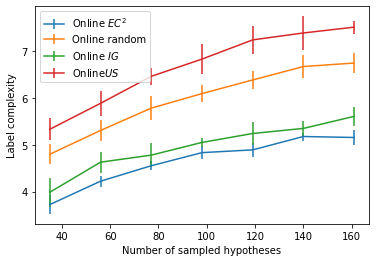

In [23]:
num_samples = list(sums_all_EC2.keys())
numtests_mean_EC2.reverse()
numtests_mean_EC2_epsgreedy.reverse()
numtests_mean_IG.reverse()
numtests_mean_IG_epsgreedy.reverse()
numtests_mean_US.reverse()
numtests_std_EC2.reverse()
numtests_std_EC2_epsgreedy.reverse()
numtests_std_IG.reverse()
numtests_std_IG_epsgreedy.reverse()
numtests_std_US.reverse()
num_samples.reverse()



plt.figure()
plt.errorbar(num_samples, numtests_mean_EC2, yerr=numtests_std_EC2,linestyle='-', label=r"Online $EC^2$")
# plt.errorbar(num_samples, numtests_mean_EC2_epsgreedy, yerr=numtests_std_EC2_epsgreedy,linestyle='-', label=r"Online $\epsilon$-greedy $EC^2$")
plt.errorbar(num_samples, numtests_mean_IG_epsgreedy, yerr=numtests_std_IG_epsgreedy,linestyle='-', label=r"Online random")
plt.errorbar(num_samples, numtests_mean_IG, yerr=numtests_std_IG,linestyle='-', label=r"Online $IG$")
plt.errorbar(num_samples, numtests_mean_US, yerr=numtests_std_US,linestyle='-', label=r"Online$US$")
plt.xlabel('Number of sampled hypotheses')
plt.ylabel('Label complexity')
plt.legend()
plt.savefig('Results/label_complexity_online'+dataset+'.eps', format='eps')


In [24]:
for k in utility_all_EC2.keys():
    utility_all_EC2[k] = [x[0] for x in utility_all_EC2[k]]
    utility_all_EC2_epsgreedy[k] = [x[0] for x in utility_all_EC2_epsgreedy[k]]
    utility_all_IG_epsgreedy[k] = [x[0] for x in utility_all_IG_epsgreedy[k]]
    utility_all_IG[k] = [x[0] for x in utility_all_IG[k]]
    utility_all_US[k] = [x[0] for x in utility_all_US[k]]
    

In [25]:



utility_mean_EC2 = [np.mean(np.array(x)) for x in utility_all_EC2.values()]
utility_mean_EC2_epsgreedy = [np.mean(np.array(x)) for x in utility_all_EC2_epsgreedy.values()]
utility_mean_IG_epsgreedy = [np.mean(np.array(x)) for x in utility_all_IG_epsgreedy.values()]
utility_mean_IG = [np.mean(np.array(x)) for x in utility_all_IG.values()]
utility_mean_US = [np.mean(np.array(x)) for x in utility_all_US.values()]


utility_std_EC2 = [np.std(np.array(x)) for x in utility_all_EC2.values()]
utility_std_EC2_epsgreedy = [np.std(np.array(x)) for x in utility_all_EC2_epsgreedy.values()]
utility_std_IG_epsgreedy = [np.std(np.array(x)) for x in utility_all_IG_epsgreedy.values()]
utility_std_IG = [np.std(np.array(x)) for x in utility_all_IG.values()]
utility_std_US = [np.std(np.array(x)) for x in utility_all_US.values()]

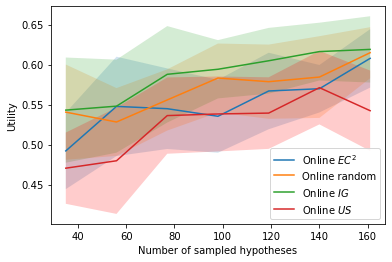

In [26]:
num_samples = list(utility_all_EC2.keys())
utility_mean_EC2.reverse()
utility_mean_EC2_epsgreedy.reverse()
utility_mean_IG_epsgreedy.reverse()
utility_mean_IG.reverse()
utility_mean_US.reverse()
utility_std_EC2.reverse()
utility_std_EC2_epsgreedy.reverse()
utility_std_IG_epsgreedy.reverse()
utility_std_IG.reverse()
utility_std_US.reverse()
num_samples.reverse()



plt.figure()
plt.plot(num_samples, utility_mean_EC2, linestyle='-', label=r"Online $EC^2$")
# plt.plot(num_samples, utility_mean_EC2_epsgreedy, linestyle='-', label=r"Online $\epsilon$-greedy $EC^2$")
plt.plot(num_samples, utility_mean_IG_epsgreedy, linestyle='-', label=r"Online random")
plt.plot(num_samples, utility_mean_IG, linestyle='-', label=r"Online $IG$")
plt.plot(num_samples, utility_mean_US, linestyle='-', label=r"Online $US$")



plt.fill_between(num_samples, np.array(utility_mean_EC2)-np.array(utility_std_EC2), np.array(utility_mean_EC2)+np.array(utility_std_EC2),alpha=0.2)
# plt.fill_between(num_samples, np.array(utility_mean_EC2_epsgreedy)-np.array(utility_std_EC2_epsgreedy), np.array(utility_mean_EC2_epsgreedy)+np.array(utility_std_EC2_epsgreedy),alpha=0.2)
plt.fill_between(num_samples, np.array(utility_mean_IG_epsgreedy)-np.array(utility_std_IG_epsgreedy), np.array(utility_mean_IG_epsgreedy)+np.array(utility_std_IG_epsgreedy),alpha=0.2)
plt.fill_between(num_samples, np.array(utility_mean_IG)-np.array(utility_std_IG), np.array(utility_mean_IG)+np.array(utility_std_IG),alpha=0.2)
plt.fill_between(num_samples, np.array(utility_mean_US)-np.array(utility_std_US), np.array(utility_mean_US)+np.array(utility_std_US), facecolor='r',alpha=0.2)


plt.xlabel('Number of sampled hypotheses')
plt.ylabel('Utility')
# plt.ylim(0.47,0.7)
plt.legend()
plt.gca().set_rasterized(True)
plt.savefig('Results/Utility_online'+dataset+'.pdf', format='pdf')



In [27]:
utils_EC2 = []
numtests_EC2 = []
for u,n in zip(utility_mean_EC2, numtests_mean_EC2):
    utils_EC2.append(u)
    numtests_EC2.append(n)
    
utils_EC2_epsgreedy = []
numtests_EC2_epsgreedy = []
for u,n in zip(utility_mean_EC2_epsgreedy, numtests_mean_EC2_epsgreedy):
    utils_EC2_epsgreedy.append(u)
    numtests_EC2_epsgreedy.append(n)
    
utils_IG_epsgreedy = []
numtests_IG_epsgreedy = []
for u,n in zip(utility_mean_IG_epsgreedy, numtests_mean_IG_epsgreedy):
    utils_IG_epsgreedy.append(u)
    numtests_IG_epsgreedy.append(n)
    
utils_IG = []
numtests_IG = []
for u,n in zip(utility_mean_IG, numtests_mean_IG):
    utils_IG.append(u)
    numtests_IG.append(n)
    
utils_US = []
numtests_US = []
for u,n in zip(utility_mean_US, numtests_mean_US):
    utils_US.append(u)
    numtests_US.append(n)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


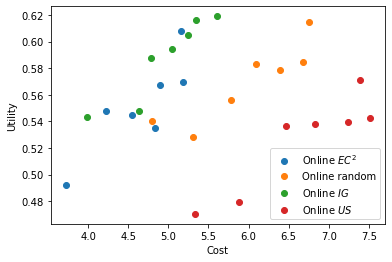

In [28]:
plt.figure()
plt.scatter(numtests_EC2, utils_EC2, label=r"Online $EC^2$")
# plt.scatter(numtests_EC2_epsgreedy, utils_EC2_epsgreedy, label=r"Online $\epsilon$-greedy $EC^2$")
plt.scatter(numtests_IG_epsgreedy, utils_IG_epsgreedy, label=r"Online random")
plt.scatter(numtests_IG, utils_IG, label=r"Online $IG$")
plt.scatter(numtests_US, utils_US, label=r"Online $US$")
plt.legend()
plt.xlabel('Cost')
plt.ylabel('Utility')
plt.savefig('Results/UtilityVSCost_EC2_IG_US_online'+dataset+'.eps', format='eps')

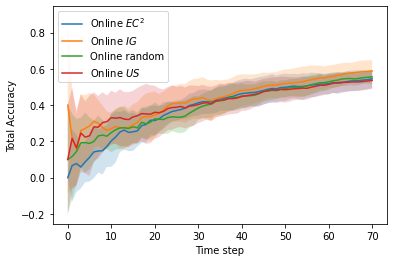

In [33]:
num_hypo_in_plot =35+21+21
plt.figure()
plt.xlabel('Time step')
plt.ylabel('Total Accuracy')

to_plot_array = np.array(utility_progress_EC2[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"Online $EC^2$")
plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0),alpha=0.2)

# to_plot_array = np.array(utility_progress_EC2_epsgreedy[num_hypo_in_plot][0]).reshape(5,-1)
# plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"Online $\epsilon$-greedy $EC^2$")
# plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0),alpha=0.2)

to_plot_array = np.array(utility_progress_IG[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"Online $IG$")
plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0),alpha=0.2)

to_plot_array = np.array(utility_progress_IG_epsgreedy[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"Online random")
plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0),alpha=0.2)

to_plot_array = np.array(utility_progress_US[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"Online $US$")
plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0),alpha=0.2)



plt.legend()
# plt.ylim(0.5, 0.75)

plt.savefig('Results/Utility_in_progress_num_hypo_'+str(num_hypo_in_plot)+'_'+dataset+'.pdf', format='pdf')


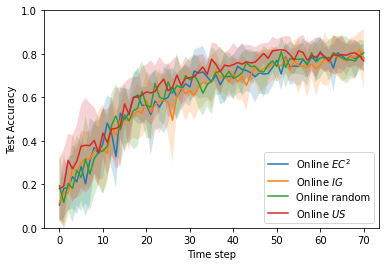

In [32]:
num_hypo_in_plot = 35+21+21
plt.figure()
plt.xlabel('Time step')
plt.ylabel('Test Accuracy')

to_plot_array = np.array(total_accuracy_progress_EC2[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"Online $EC^2$")
plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0),alpha=0.2)

to_plot_array = np.array(total_accuracy_progress_IG[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"Online $IG$")
plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0),alpha=0.2)

to_plot_array = np.array(total_accuracy_progress_IG_epsgreedy[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"Online random")
plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0),alpha=0.2)

to_plot_array = np.array(total_accuracy_progress_US[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"Online $US$")
plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0),alpha=0.2)




plt.legend()
plt.ylim(0.0, 1.0)

plt.savefig('Results/TestUtility_in_progress_num_hypo_'+str(num_hypo_in_plot)+'_'+dataset+'.pdf', format='pdf')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(3100.0, 3600.0)

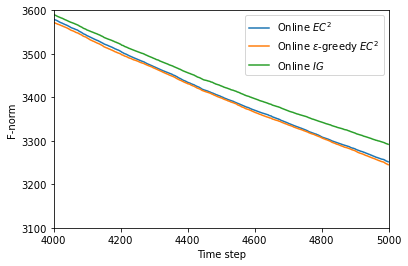

In [50]:
plt.figure()
plt.xlabel('Time step')
plt.ylabel('F-norm')
plt.plot(norm_progress_EC2[num_hypo_in_plot], linestyle='-', label=r"Online $EC^2$")
plt.plot(norm_progress_EC2_epsgreedy[num_hypo_in_plot], linestyle='-', label=r"Online $\epsilon$-greedy $EC^2$")
plt.plot(norm_progress_IG[num_hypo_in_plot], linestyle='-', label=r"Online $IG$")
plt.legend()
plt.savefig('Running_norm_'+dataset+'.eps', format='eps')
plt.xlim(4000, 5000)
plt.ylim(3100, 3600)

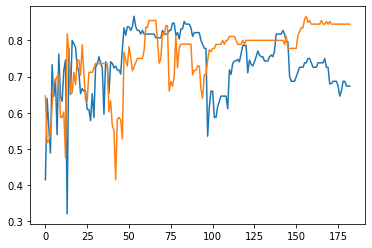

In [47]:
plt.plot(total_accuracy_progress_EC2[40][0][241*7:241*8])
plt.plot(total_accuracy_progress_IG[40][0][241*7:241*8])
# plt.plot(total_accuracy_progress_EC2[28][0][:241])

ZeroDivisionError: integer division or modulo by zero

<Figure size 432x288 with 0 Axes>

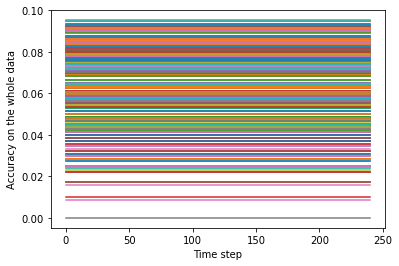

In [93]:
plt.figure()
num_hypo_in_plot = 40
plt.figure()
plt.xlabel('Time step')
plt.ylabel('Accuracy on the whole data')
plt.plot(np.array(total_accuracy_progress_EC2[num_hypo_in_plot])/len(random_states), linestyle='-', label=r"Online $EC^2$")
plt.plot(np.array(total_accuracy_progress_EC2_epsgreedy[num_hypo_in_plot])/len(random_states), linestyle='-', label=r"Online $\epsilon$-greedy $EC^2$")
plt.plot(np.array(total_accuracy_progress_IG[num_hypo_in_plot])/len(random_states), linestyle='-', label=r"Online $IG$")
plt.legend()
plt.ylim(0.4, 0.77)
plt.xlim(0, 500)
plt.savefig('total_accuracy_' + dataset+'_' + str(num_hypo_in_plot) + '.eps', format='eps')

In [35]:
inverse_norms = []
total_accuracies = []

for tot_acc, inv_norm in zip(total_accuracy_progress_EC2.values(), norm_progress_EC2.values()):
    inverse_norms += inv_norm
    total_accuracies += tot_acc
    
inverse_norms_IG = []
total_accuracies_IG = []
    
for tot_acc, inv_norm in zip(total_accuracy_progress_IG.values(), norm_progress_IG.values()):
    inverse_norms_IG += inv_norm
    total_accuracies_IG += tot_acc
    
# inverse_norms = list(1.0/np.array(inverse_norms))
# inverse_norms_IG = list(1.0/np.array(inverse_norms_IG))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


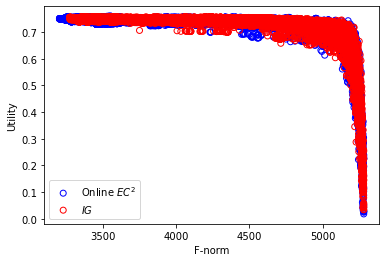

In [42]:
plt.figure()
plt.scatter(inverse_norms, total_accuracies, facecolors='none', edgecolors='b', label=r"Online $EC^2$")
plt.scatter(inverse_norms_IG, total_accuracies_IG, facecolors='none', edgecolors='r', label=r"$IG$")
# plt.scatter(numtests_US, utils_US, color='g', label=r"$US$")
plt.legend()
plt.xlabel('F-norm')
plt.ylabel('Utility')
plt.savefig('UtilityVSInverseF-norm_EC2_IG_US_online'+dataset+'.eps', format='eps')

# Test with different criteria
## Total hypotheses samples: 10-105
### Train data

In [11]:
sums_all_EC2 = {}
sums_all_IG = {}
sums_all_US = {}

utility_all_EC2 = {}
utility_all_IG = {}
utility_all_US = {}


for num_sampled_hypos in range(10, 110, 5):

    accs_all = []
    all_sum = []
    for rand_state in random_states:
        print('random state = '+ str(rand_state))
        theta, priors, test_csv, data_csv = estimate_priors_and_theta('data_big.csv', rand_state=rand_state) 
        hypothses, decision_regions = sample_hypotheses(N=2000, theta=theta, priors=priors, random_state=rand_state, total_samples=num_sampled_hypos)
        accs = []

        for max_steps in max_steps_values:
            y_pred = []
            y_true = []
            print(max_steps)
            sum_queries = 0 
            for i in range(len(data_csv)):
                doc = data_csv.iloc[i].to_dict()
                obs, y, y_hat = decision_tree_learning(doc,theta,max_steps, priors, hypothses, decision_regions, 'EC2')
    #             print(len(obs.items()))
                sum_queries+=len(obs.items())
                y_true.append(y)
                y_pred.append(y_hat)
            accs.append(accuracy_score(y_true, y_pred))
    #         print(sum_queries)
        all_sum.append(sum_queries)
        accs_all.append(accs)
        print('all accuracies so far:')
        print(accs_all)
        print(all_sum)


    accs_all_IG = []
    all_sum_IG = []
    for rand_state in random_states:
        print('random state = '+ str(rand_state))
        theta, priors, test_csv, data_csv = estimate_priors_and_theta('data_big.csv', rand_state=rand_state) 
        hypothses, decision_regions = sample_hypotheses(N=2000, theta=theta, priors=priors, random_state=rand_state,total_samples=num_sampled_hypos)
        accs_IG = []

        for max_steps in max_steps_values:
            y_pred = []
            y_true = []
            print(max_steps)
            sum_queries_IG = 0
            for i in range(len(data_csv)):
                doc = data_csv.iloc[i].to_dict()
                obs, y, y_hat = decision_tree_learning(doc,theta,max_steps, priors, hypothses, decision_regions, 'IG')
    #             print(len(obs.items()))
                sum_queries_IG+=len(obs.items())
                y_true.append(y)
                y_pred.append(y_hat)
            accs_IG.append(accuracy_score(y_true, y_pred))
    #         print(sum_queries_IG)
        accs_all_IG.append(accs_IG)
        all_sum_IG.append(sum_queries_IG)
        print('all accuracies so far:')
        print(accs_all_IG)
        print(all_sum_IG)



    accs_all_US = []
    all_sum_US = []
    for rand_state in random_states:
        print('random state = '+ str(rand_state))
        theta, priors, test_csv, data_csv = estimate_priors_and_theta('data_big.csv', rand_state=rand_state) 
        hypothses, decision_regions = sample_hypotheses(N=2000, theta=theta, priors=priors, random_state=rand_state, total_samples=num_sampled_hypos)
        accs_US = []

        for max_steps in max_steps_values:
            y_pred = []
            y_true = []
            print(max_steps)
            sum_queries_US = 0
            for i in range(len(data_csv)):
                doc = data_csv.iloc[i].to_dict()
                obs, y, y_hat = decision_tree_learning(doc,theta,max_steps, priors, hypothses, decision_regions, 'US')
                sum_queries_US+=len(obs.items())
                y_true.append(y)
                y_pred.append(y_hat)
            accs_US.append(accuracy_score(y_true, y_pred))
        accs_all_US.append(accs_US)
        all_sum_US.append(sum_queries_US)
        print('all accuracies so far:')
        print(accs_all_US)
        print(all_sum_US)


    sums_all_EC2[num_sampled_hypos] = all_sum
    sums_all_IG[num_sampled_hypos] = all_sum_IG
    sums_all_US[num_sampled_hypos] = all_sum_US

    utility_all_EC2[num_sampled_hypos] = accs_all
    utility_all_IG[num_sampled_hypos] = accs_all_IG
    utility_all_US[num_sampled_hypos] = accs_all_US





random state = 100
7
all accuracies so far:
[[0.52925]]
[24345]
random state = 101
7
all accuracies so far:
[[0.52925], [0.593875]]
[24345, 25980]
random state = 102
7
all accuracies so far:
[[0.52925], [0.593875], [0.470375]]
[24345, 25980, 25564]
random state = 103
7
all accuracies so far:
[[0.52925], [0.593875], [0.470375], [0.526]]
[24345, 25980, 25564, 26376]
random state = 104
7
all accuracies so far:
[[0.52925], [0.593875], [0.470375], [0.526], [0.477125]]
[24345, 25980, 25564, 26376, 22602]
random state = 105
7
all accuracies so far:
[[0.52925], [0.593875], [0.470375], [0.526], [0.477125], [0.58325]]
[24345, 25980, 25564, 26376, 22602, 26304]
random state = 106
7
all accuracies so far:
[[0.52925], [0.593875], [0.470375], [0.526], [0.477125], [0.58325], [0.531125]]
[24345, 25980, 25564, 26376, 22602, 26304, 25964]
random state = 107
7
all accuracies so far:
[[0.52925], [0.593875], [0.470375], [0.526], [0.477125], [0.58325], [0.531125], [0.464375]]
[24345, 25980, 25564, 26376, 22

all accuracies so far:
[[0.53125], [0.577], [0.591], [0.50575], [0.59225], [0.705125], [0.597125], [0.599875], [0.58], [0.5765], [0.52525], [0.645625], [0.523875], [0.583], [0.70975], [0.591625], [0.651], [0.641375], [0.5235]]
[24889, 27636, 28707, 28202, 24258, 28948, 28973, 26592, 29794, 29184, 26529, 27488, 25309, 25595, 27157, 24250, 28759, 27401, 26927]
random state = 119
7
all accuracies so far:
[[0.53125], [0.577], [0.591], [0.50575], [0.59225], [0.705125], [0.597125], [0.599875], [0.58], [0.5765], [0.52525], [0.645625], [0.523875], [0.583], [0.70975], [0.591625], [0.651], [0.641375], [0.5235], [0.594875]]
[24889, 27636, 28707, 28202, 24258, 28948, 28973, 26592, 29794, 29184, 26529, 27488, 25309, 25595, 27157, 24250, 28759, 27401, 26927, 29937]
random state = 100
7
all accuracies so far:
[[0.47175]]
[35724]
random state = 101
7
all accuracies so far:
[[0.47175], [0.53275]]
[35724, 32743]
random state = 102
7
all accuracies so far:
[[0.47175], [0.53275], [0.542875]]
[35724, 32743

all accuracies so far:
[[0.525125], [0.59275], [0.59], [0.581875], [0.592375], [0.5835], [0.60025], [0.541875], [0.599625], [0.539], [0.5895], [0.54175], [0.53475], [0.54175], [0.65425], [0.601375]]
[26215, 26976, 25765, 25828, 27386, 29616, 29036, 26094, 27102, 25672, 27518, 27162, 26857, 27182, 27416, 28014]
random state = 116
7
all accuracies so far:
[[0.525125], [0.59275], [0.59], [0.581875], [0.592375], [0.5835], [0.60025], [0.541875], [0.599625], [0.539], [0.5895], [0.54175], [0.53475], [0.54175], [0.65425], [0.601375], [0.5835]]
[26215, 26976, 25765, 25828, 27386, 29616, 29036, 26094, 27102, 25672, 27518, 27162, 26857, 27182, 27416, 28014, 28983]
random state = 117
7
all accuracies so far:
[[0.525125], [0.59275], [0.59], [0.581875], [0.592375], [0.5835], [0.60025], [0.541875], [0.599625], [0.539], [0.5895], [0.54175], [0.53475], [0.54175], [0.65425], [0.601375], [0.5835], [0.642625]]
[26215, 26976, 25765, 25828, 27386, 29616, 29036, 26094, 27102, 25672, 27518, 27162, 26857, 2718

all accuracies so far:
[[0.515125], [0.533375], [0.545125], [0.58075], [0.578125], [0.49375], [0.53775], [0.43825], [0.573], [0.62275], [0.48875], [0.581125]]
[38366, 36379, 38698, 37864, 40862, 38728, 38612, 32617, 39218, 41436, 37834, 40892]
random state = 112
7
all accuracies so far:
[[0.515125], [0.533375], [0.545125], [0.58075], [0.578125], [0.49375], [0.53775], [0.43825], [0.573], [0.62275], [0.48875], [0.581125], [0.52875]]
[38366, 36379, 38698, 37864, 40862, 38728, 38612, 32617, 39218, 41436, 37834, 40892, 38234]
random state = 113
7
all accuracies so far:
[[0.515125], [0.533375], [0.545125], [0.58075], [0.578125], [0.49375], [0.53775], [0.43825], [0.573], [0.62275], [0.48875], [0.581125], [0.52875], [0.524625]]
[38366, 36379, 38698, 37864, 40862, 38728, 38612, 32617, 39218, 41436, 37834, 40892, 38234, 41696]
random state = 114
7
all accuracies so far:
[[0.515125], [0.533375], [0.545125], [0.58075], [0.578125], [0.49375], [0.53775], [0.43825], [0.573], [0.62275], [0.48875], [0.

all accuracies so far:
[[0.718875], [0.660125], [0.650625], [0.648625], [0.66475], [0.707375]]
[32552, 31538, 34609, 32765, 28220, 32018]
random state = 106
7
all accuracies so far:
[[0.718875], [0.660125], [0.650625], [0.648625], [0.66475], [0.707375], [0.721375]]
[32552, 31538, 34609, 32765, 28220, 32018, 34694]
random state = 107
7
all accuracies so far:
[[0.718875], [0.660125], [0.650625], [0.648625], [0.66475], [0.707375], [0.721375], [0.724125]]
[32552, 31538, 34609, 32765, 28220, 32018, 34694, 31193]
random state = 108
7
all accuracies so far:
[[0.718875], [0.660125], [0.650625], [0.648625], [0.66475], [0.707375], [0.721375], [0.724125], [0.72275]]
[32552, 31538, 34609, 32765, 28220, 32018, 34694, 31193, 35018]
random state = 109
7
all accuracies so far:
[[0.718875], [0.660125], [0.650625], [0.648625], [0.66475], [0.707375], [0.721375], [0.724125], [0.72275], [0.707875]]
[32552, 31538, 34609, 32765, 28220, 32018, 34694, 31193, 35018, 35798]
random state = 110
7
all accuracies so

all accuracies so far:
[[0.583125], [0.54125], [0.589625], [0.632375], [0.59525], [0.50575], [0.6245], [0.534125], [0.630375], [0.625875], [0.49025], [0.635625], [0.5745], [0.5805], [0.58525], [0.588375], [0.58975], [0.584375], [0.63225]]
[41711, 38279, 40634, 40479, 41919, 42287, 42527, 41490, 40834, 44463, 40556, 43737, 42807, 43446, 43283, 43275, 40706, 45367, 44526]
random state = 119
7
all accuracies so far:
[[0.583125], [0.54125], [0.589625], [0.632375], [0.59525], [0.50575], [0.6245], [0.534125], [0.630375], [0.625875], [0.49025], [0.635625], [0.5745], [0.5805], [0.58525], [0.588375], [0.58975], [0.584375], [0.63225], [0.585875]]
[41711, 38279, 40634, 40479, 41919, 42287, 42527, 41490, 40834, 44463, 40556, 43737, 42807, 43446, 43283, 43275, 40706, 45367, 44526, 41094]
random state = 100
7
all accuracies so far:
[[0.71775]]
[30753]
random state = 101
7
all accuracies so far:
[[0.71775], [0.609375]]
[30753, 31558]
random state = 102
7
all accuracies so far:
[[0.71775], [0.609375],

all accuracies so far:
[[0.72475], [0.718375], [0.650625], [0.7175], [0.72175], [0.70875], [0.731875], [0.723375], [0.735125], [0.711375], [0.71475], [0.716875], [0.664125], [0.730375], [0.726625], [0.72075]]
[32861, 34717, 34609, 34926, 30562, 32871, 35040, 32584, 36018, 37277, 35484, 34674, 32694, 35384, 32367, 32527]
random state = 116
7
all accuracies so far:
[[0.72475], [0.718375], [0.650625], [0.7175], [0.72175], [0.70875], [0.731875], [0.723375], [0.735125], [0.711375], [0.71475], [0.716875], [0.664125], [0.730375], [0.726625], [0.72075], [0.717875]]
[32861, 34717, 34609, 34926, 30562, 32871, 35040, 32584, 36018, 37277, 35484, 34674, 32694, 35384, 32367, 32527, 36047]
random state = 117
7
all accuracies so far:
[[0.72475], [0.718375], [0.650625], [0.7175], [0.72175], [0.70875], [0.731875], [0.723375], [0.735125], [0.711375], [0.71475], [0.716875], [0.664125], [0.730375], [0.726625], [0.72075], [0.717875], [0.71925]]
[32861, 34717, 34609, 34926, 30562, 32871, 35040, 32584, 36018,

all accuracies so far:
[[0.7245], [0.6605], [0.7105], [0.706125], [0.67375], [0.711875], [0.725625], [0.7175], [0.71875], [0.73425], [0.70575], [0.72375]]
[33176, 31661, 31363, 32293, 33829, 31939, 32657, 32246, 34524, 33553, 32172, 32201]
random state = 112
7
all accuracies so far:
[[0.7245], [0.6605], [0.7105], [0.706125], [0.67375], [0.711875], [0.725625], [0.7175], [0.71875], [0.73425], [0.70575], [0.72375], [0.67375]]
[33176, 31661, 31363, 32293, 33829, 31939, 32657, 32246, 34524, 33553, 32172, 32201, 32391]
random state = 113
7
all accuracies so far:
[[0.7245], [0.6605], [0.7105], [0.706125], [0.67375], [0.711875], [0.725625], [0.7175], [0.71875], [0.73425], [0.70575], [0.72375], [0.67375], [0.718875]]
[33176, 31661, 31363, 32293, 33829, 31939, 32657, 32246, 34524, 33553, 32172, 32201, 32391, 32393]
random state = 114
7
all accuracies so far:
[[0.7245], [0.6605], [0.7105], [0.706125], [0.67375], [0.711875], [0.725625], [0.7175], [0.71875], [0.73425], [0.70575], [0.72375], [0.6737

all accuracies so far:
[[0.592625], [0.602625], [0.639625], [0.65725], [0.605625], [0.64725]]
[46519, 46123, 45026, 48064, 45432, 46881]
random state = 106
7
all accuracies so far:
[[0.592625], [0.602625], [0.639625], [0.65725], [0.605625], [0.64725], [0.649875]]
[46519, 46123, 45026, 48064, 45432, 46881, 46144]
random state = 107
7
all accuracies so far:
[[0.592625], [0.602625], [0.639625], [0.65725], [0.605625], [0.64725], [0.649875], [0.636375]]
[46519, 46123, 45026, 48064, 45432, 46881, 46144, 47499]
random state = 108
7
all accuracies so far:
[[0.592625], [0.602625], [0.639625], [0.65725], [0.605625], [0.64725], [0.649875], [0.636375], [0.646]]
[46519, 46123, 45026, 48064, 45432, 46881, 46144, 47499, 47210]
random state = 109
7
all accuracies so far:
[[0.592625], [0.602625], [0.639625], [0.65725], [0.605625], [0.64725], [0.649875], [0.636375], [0.646], [0.651125]]
[46519, 46123, 45026, 48064, 45432, 46881, 46144, 47499, 47210, 46920]
random state = 110
7
all accuracies so far:
[[0

all accuracies so far:
[[0.7255], [0.712625], [0.7085], [0.7125], [0.680125], [0.716375], [0.723125], [0.73], [0.728625], [0.726625], [0.71425], [0.715875], [0.673125], [0.72375], [0.727625], [0.706625], [0.72475], [0.655375], [0.714625]]
[33176, 32262, 31646, 32986, 34730, 33667, 31796, 33478, 34076, 32824, 33184, 33231, 33896, 33311, 34171, 31984, 33025, 34669, 31819]
random state = 119
7
all accuracies so far:
[[0.7255], [0.712625], [0.7085], [0.7125], [0.680125], [0.716375], [0.723125], [0.73], [0.728625], [0.726625], [0.71425], [0.715875], [0.673125], [0.72375], [0.727625], [0.706625], [0.72475], [0.655375], [0.714625], [0.71625]]
[33176, 32262, 31646, 32986, 34730, 33667, 31796, 33478, 34076, 32824, 33184, 33231, 33896, 33311, 34171, 31984, 33025, 34669, 31819, 32514]
random state = 100
7
all accuracies so far:
[[0.73025]]
[33753]
random state = 101
7
all accuracies so far:
[[0.73025], [0.72375]]
[33753, 35685]
random state = 102
7
all accuracies so far:
[[0.73025], [0.72375], [0

all accuracies so far:
[[0.647], [0.66025], [0.6525], [0.66925], [0.621375], [0.66325], [0.65975], [0.64725], [0.66075], [0.661875], [0.665375], [0.653875], [0.6495], [0.66125], [0.650625], [0.615375]]
[48315, 47767, 47404, 49150, 48213, 49111, 47320, 48064, 48463, 47430, 48544, 48382, 47626, 48408, 46562, 47502]
random state = 116
7
all accuracies so far:
[[0.647], [0.66025], [0.6525], [0.66925], [0.621375], [0.66325], [0.65975], [0.64725], [0.66075], [0.661875], [0.665375], [0.653875], [0.6495], [0.66125], [0.650625], [0.615375], [0.643375]]
[48315, 47767, 47404, 49150, 48213, 49111, 47320, 48064, 48463, 47430, 48544, 48382, 47626, 48408, 46562, 47502, 47557]
random state = 117
7
all accuracies so far:
[[0.647], [0.66025], [0.6525], [0.66925], [0.621375], [0.66325], [0.65975], [0.64725], [0.66075], [0.661875], [0.665375], [0.653875], [0.6495], [0.66125], [0.650625], [0.615375], [0.643375], [0.617375]]
[48315, 47767, 47404, 49150, 48213, 49111, 47320, 48064, 48463, 47430, 48544, 48382

all accuracies so far:
[[0.736875], [0.736375], [0.720625], [0.732375], [0.73175], [0.720625], [0.74175], [0.739625], [0.744], [0.73675], [0.726625], [0.730125]]
[34127, 36385, 38754, 37134, 32352, 37080, 35784, 35504, 38967, 39499, 37504, 36844]
random state = 112
7
all accuracies so far:
[[0.736875], [0.736375], [0.720625], [0.732375], [0.73175], [0.720625], [0.74175], [0.739625], [0.744], [0.73675], [0.726625], [0.730125], [0.7305]]
[34127, 36385, 38754, 37134, 32352, 37080, 35784, 35504, 38967, 39499, 37504, 36844, 37426]
random state = 113
7
all accuracies so far:
[[0.736875], [0.736375], [0.720625], [0.732375], [0.73175], [0.720625], [0.74175], [0.739625], [0.744], [0.73675], [0.726625], [0.730125], [0.7305], [0.739]]
[34127, 36385, 38754, 37134, 32352, 37080, 35784, 35504, 38967, 39499, 37504, 36844, 37426, 37384]
random state = 114
7
all accuracies so far:
[[0.736875], [0.736375], [0.720625], [0.732375], [0.73175], [0.720625], [0.74175], [0.739625], [0.744], [0.73675], [0.72662

all accuracies so far:
[[0.7445], [0.729625], [0.722875], [0.71725], [0.740375], [0.68775]]
[35979, 33192, 33769, 34318, 33336, 32118]
random state = 106
7
all accuracies so far:
[[0.7445], [0.729625], [0.722875], [0.71725], [0.740375], [0.68775], [0.723125]]
[35979, 33192, 33769, 34318, 33336, 32118, 32639]
random state = 107
7
all accuracies so far:
[[0.7445], [0.729625], [0.722875], [0.71725], [0.740375], [0.68775], [0.723125], [0.73325]]
[35979, 33192, 33769, 34318, 33336, 32118, 32639, 33893]
random state = 108
7
all accuracies so far:
[[0.7445], [0.729625], [0.722875], [0.71725], [0.740375], [0.68775], [0.723125], [0.73325], [0.728]]
[35979, 33192, 33769, 34318, 33336, 32118, 32639, 33893, 35725]
random state = 109
7
all accuracies so far:
[[0.7445], [0.729625], [0.722875], [0.71725], [0.740375], [0.68775], [0.723125], [0.73325], [0.728], [0.739125]]
[35979, 33192, 33769, 34318, 33336, 32118, 32639, 33893, 35725, 33713]
random state = 110
7
all accuracies so far:
[[0.7445], [0.72

all accuracies so far:
[[0.735875], [0.737], [0.720625], [0.732375], [0.737375], [0.72175], [0.74125], [0.74475], [0.74425], [0.73675], [0.7305], [0.734625], [0.729375], [0.739875], [0.736625], [0.7235], [0.731625], [0.742625], [0.73975], [0.731875]]
[35084, 37193, 38754, 38152, 33359, 37376, 36056, 35722, 39894, 39569, 37890, 37110, 38734, 38238, 32768, 36672, 37613, 37546, 38986, 38836]
random state = 100
7
all accuracies so far:
[[0.674375]]
[50997]
random state = 101
7
all accuracies so far:
[[0.674375], [0.69225]]
[50997, 49715]
random state = 102
7
all accuracies so far:
[[0.674375], [0.69225], [0.683875]]
[50997, 49715, 50076]
random state = 103
7
all accuracies so far:
[[0.674375], [0.69225], [0.683875], [0.69575]]
[50997, 49715, 50076, 50986]
random state = 104
7
all accuracies so far:
[[0.674375], [0.69225], [0.683875], [0.69575], [0.685875]]
[50997, 49715, 50076, 50986, 50659]
random state = 105
7
all accuracies so far:
[[0.674375], [0.69225], [0.683875], [0.69575], [0.68587

all accuracies so far:
[[0.746125], [0.726125], [0.735125], [0.724125], [0.72975], [0.71775], [0.718875], [0.733875], [0.739875], [0.74375], [0.7195], [0.734], [0.6815], [0.722], [0.739125], [0.7195], [0.735625]]
[36793, 34108, 34115, 37973, 32847, 33872, 31983, 35435, 37345, 34071, 36414, 33658, 35717, 34103, 35006, 31914, 37255]
random state = 117
7
all accuracies so far:
[[0.746125], [0.726125], [0.735125], [0.724125], [0.72975], [0.71775], [0.718875], [0.733875], [0.739875], [0.74375], [0.7195], [0.734], [0.6815], [0.722], [0.739125], [0.7195], [0.735625], [0.737125]]
[36793, 34108, 34115, 37973, 32847, 33872, 31983, 35435, 37345, 34071, 36414, 33658, 35717, 34103, 35006, 31914, 37255, 37453]
random state = 118
7
all accuracies so far:
[[0.746125], [0.726125], [0.735125], [0.724125], [0.72975], [0.71775], [0.718875], [0.733875], [0.739875], [0.74375], [0.7195], [0.734], [0.6815], [0.722], [0.739125], [0.7195], [0.735625], [0.737125], [0.740125]]
[36793, 34108, 34115, 37973, 32847, 

all accuracies so far:
[[0.69925], [0.70125], [0.69325], [0.709125], [0.69075], [0.6905], [0.696125], [0.675875], [0.697], [0.70275], [0.690625], [0.68325], [0.700625]]
[51997, 50157, 51898, 51549, 51188, 50924, 51068, 50121, 50998, 50744, 50532, 51641, 50563]
random state = 113
7
all accuracies so far:
[[0.69925], [0.70125], [0.69325], [0.709125], [0.69075], [0.6905], [0.696125], [0.675875], [0.697], [0.70275], [0.690625], [0.68325], [0.700625], [0.6985]]
[51997, 50157, 51898, 51549, 51188, 50924, 51068, 50121, 50998, 50744, 50532, 51641, 50563, 51630]
random state = 114
7
all accuracies so far:
[[0.69925], [0.70125], [0.69325], [0.709125], [0.69075], [0.6905], [0.696125], [0.675875], [0.697], [0.70275], [0.690625], [0.68325], [0.700625], [0.6985], [0.697]]
[51997, 50157, 51898, 51549, 51188, 50924, 51068, 50121, 50998, 50744, 50532, 51641, 50563, 51630, 50824]
random state = 115
7
all accuracies so far:
[[0.69925], [0.70125], [0.69325], [0.709125], [0.69075], [0.6905], [0.696125], [0

all accuracies so far:
[[0.74625], [0.743875], [0.732375], [0.73925], [0.743], [0.737], [0.7425]]
[35370, 37864, 41635, 39535, 35213, 38969, 36266]
random state = 107
7
all accuracies so far:
[[0.74625], [0.743875], [0.732375], [0.73925], [0.743], [0.737], [0.7425], [0.7505]]
[35370, 37864, 41635, 39535, 35213, 38969, 36266, 39516]
random state = 108
7
all accuracies so far:
[[0.74625], [0.743875], [0.732375], [0.73925], [0.743], [0.737], [0.7425], [0.7505], [0.74975]]
[35370, 37864, 41635, 39535, 35213, 38969, 36266, 39516, 40254]
random state = 109
7
all accuracies so far:
[[0.74625], [0.743875], [0.732375], [0.73925], [0.743], [0.737], [0.7425], [0.7505], [0.74975], [0.753625]]
[35370, 37864, 41635, 39535, 35213, 38969, 36266, 39516, 40254, 41918]
random state = 110
7
all accuracies so far:
[[0.74625], [0.743875], [0.732375], [0.73925], [0.743], [0.737], [0.7425], [0.7505], [0.74975], [0.753625], [0.736875]]
[35370, 37864, 41635, 39535, 35213, 38969, 36266, 39516, 40254, 41918, 3821

all accuracies so far:
[[0.7055], [0.7045], [0.70775], [0.713875], [0.704875], [0.701375], [0.71175], [0.692375], [0.703875], [0.71225], [0.70675], [0.6965], [0.711875], [0.714625], [0.70775], [0.712], [0.687875], [0.697875], [0.712875], [0.702125]]
[52489, 50883, 52441, 51813, 52235, 51473, 51643, 50596, 51567, 52059, 51110, 52037, 50798, 52132, 51475, 51409, 51627, 52418, 50874, 51721]
random state = 100
7
all accuracies so far:
[[0.745375]]
[35655]
random state = 101
7
all accuracies so far:
[[0.745375], [0.737]]
[35655, 35260]
random state = 102
7
all accuracies so far:
[[0.745375], [0.737], [0.745375]]
[35655, 35260, 38390]
random state = 103
7
all accuracies so far:
[[0.745375], [0.737], [0.745375], [0.73125]]
[35655, 35260, 38390, 39053]
random state = 104
7
all accuracies so far:
[[0.745375], [0.737], [0.745375], [0.73125], [0.744625]]
[35655, 35260, 38390, 39053, 35162]
random state = 105
7
all accuracies so far:
[[0.745375], [0.737], [0.745375], [0.73125], [0.744625], [0.7298

all accuracies so far:
[[0.74625], [0.75025], [0.74325], [0.744625], [0.743], [0.740875], [0.743], [0.750875], [0.74975], [0.754375], [0.736625], [0.7445], [0.735], [0.75], [0.748375], [0.733625], [0.73575]]
[36927, 38103, 42179, 39672, 35213, 39256, 38123, 39634, 40254, 42893, 39074, 38973, 39297, 39054, 36582, 38497, 39575]
random state = 117
7
all accuracies so far:
[[0.74625], [0.75025], [0.74325], [0.744625], [0.743], [0.740875], [0.743], [0.750875], [0.74975], [0.754375], [0.736625], [0.7445], [0.735], [0.75], [0.748375], [0.733625], [0.73575], [0.748125]]
[36927, 38103, 42179, 39672, 35213, 39256, 38123, 39634, 40254, 42893, 39074, 38973, 39297, 39054, 36582, 38497, 39575, 39416]
random state = 118
7
all accuracies so far:
[[0.74625], [0.75025], [0.74325], [0.744625], [0.743], [0.740875], [0.743], [0.750875], [0.74975], [0.754375], [0.736625], [0.7445], [0.735], [0.75], [0.748375], [0.733625], [0.73575], [0.748125], [0.752375]]
[36927, 38103, 42179, 39672, 35213, 39256, 38123, 3

all accuracies so far:
[[0.74725], [0.75], [0.7365], [0.7395], [0.749125], [0.744125], [0.742625], [0.7455], [0.735375], [0.747625], [0.736875], [0.741625], [0.7495], [0.750625]]
[36150, 38759, 36991, 39381, 36021, 36309, 36383, 38169, 37072, 36418, 35336, 36121, 37559, 36805]
random state = 114
7
all accuracies so far:
[[0.74725], [0.75], [0.7365], [0.7395], [0.749125], [0.744125], [0.742625], [0.7455], [0.735375], [0.747625], [0.736875], [0.741625], [0.7495], [0.750625], [0.749875]]
[36150, 38759, 36991, 39381, 36021, 36309, 36383, 38169, 37072, 36418, 35336, 36121, 37559, 36805, 37168]
random state = 115
7
all accuracies so far:
[[0.74725], [0.75], [0.7365], [0.7395], [0.749125], [0.744125], [0.742625], [0.7455], [0.735375], [0.747625], [0.736875], [0.741625], [0.7495], [0.750625], [0.749875], [0.746125]]
[36150, 38759, 36991, 39381, 36021, 36309, 36383, 38169, 37072, 36418, 35336, 36121, 37559, 36805, 37168, 34963]
random state = 116
7
all accuracies so far:
[[0.74725], [0.75], [0.

all accuracies so far:
[[0.7325], [0.720125], [0.714625], [0.720875], [0.726125], [0.71425], [0.718875], [0.72375], [0.724625]]
[53449, 51967, 53042, 52295, 53456, 52376, 52643, 51971, 53021]
random state = 109
7
all accuracies so far:
[[0.7325], [0.720125], [0.714625], [0.720875], [0.726125], [0.71425], [0.718875], [0.72375], [0.724625], [0.7235]]
[53449, 51967, 53042, 52295, 53456, 52376, 52643, 51971, 53021, 52778]
random state = 110
7
all accuracies so far:
[[0.7325], [0.720125], [0.714625], [0.720875], [0.726125], [0.71425], [0.718875], [0.72375], [0.724625], [0.7235], [0.71825]]
[53449, 51967, 53042, 52295, 53456, 52376, 52643, 51971, 53021, 52778, 52609]
random state = 111
7
all accuracies so far:
[[0.7325], [0.720125], [0.714625], [0.720875], [0.726125], [0.71425], [0.718875], [0.72375], [0.724625], [0.7235], [0.71825], [0.724625]]
[53449, 51967, 53042, 52295, 53456, 52376, 52643, 51971, 53021, 52778, 52609, 53257]
random state = 112
7
all accuracies so far:
[[0.7325], [0.72012

all accuracies so far:
[[0.746625]]
[37918]
random state = 101
7
all accuracies so far:
[[0.746625], [0.751375]]
[37918, 38274]
random state = 102
7
all accuracies so far:
[[0.746625], [0.751375], [0.753375]]
[37918, 38274, 42549]
random state = 103
7
all accuracies so far:
[[0.746625], [0.751375], [0.753375], [0.744375]]
[37918, 38274, 42549, 41915]
random state = 104
7
all accuracies so far:
[[0.746625], [0.751375], [0.753375], [0.744375], [0.747]]
[37918, 38274, 42549, 41915, 36783]
random state = 105
7
all accuracies so far:
[[0.746625], [0.751375], [0.753375], [0.744375], [0.747], [0.74625]]
[37918, 38274, 42549, 41915, 36783, 39764]
random state = 106
7
all accuracies so far:
[[0.746625], [0.751375], [0.753375], [0.744375], [0.747], [0.74625], [0.752625]]
[37918, 38274, 42549, 41915, 36783, 39764, 39199]
random state = 107
7
all accuracies so far:
[[0.746625], [0.751375], [0.753375], [0.744375], [0.747], [0.74625], [0.752625], [0.751]]
[37918, 38274, 42549, 41915, 36783, 39764, 3

all accuracies so far:
[[0.738875], [0.721125], [0.72525], [0.7225], [0.731625], [0.724375], [0.725], [0.72975], [0.74325], [0.73325], [0.731875], [0.73], [0.74025], [0.736], [0.73425], [0.74475], [0.726625], [0.732]]
[53785, 52142, 53393, 52756, 53861, 52939, 52936, 52493, 54034, 53284, 53421, 53741, 52772, 53341, 52903, 53259, 52721, 53664]
random state = 118
7
all accuracies so far:
[[0.738875], [0.721125], [0.72525], [0.7225], [0.731625], [0.724375], [0.725], [0.72975], [0.74325], [0.73325], [0.731875], [0.73], [0.74025], [0.736], [0.73425], [0.74475], [0.726625], [0.732], [0.725875]]
[53785, 52142, 53393, 52756, 53861, 52939, 52936, 52493, 54034, 53284, 53421, 53741, 52772, 53341, 52903, 53259, 52721, 53664, 52376]
random state = 119
7
all accuracies so far:
[[0.738875], [0.721125], [0.72525], [0.7225], [0.731625], [0.724375], [0.725], [0.72975], [0.74325], [0.73325], [0.731875], [0.73], [0.74025], [0.736], [0.73425], [0.74475], [0.726625], [0.732], [0.725875], [0.726625]]
[53785,

all accuracies so far:
[[0.74625], [0.75125], [0.753375], [0.74475], [0.747125], [0.74675], [0.7525], [0.751625], [0.751125], [0.754625], [0.748125], [0.7495], [0.7465], [0.75525], [0.752125]]
[40356, 38392, 42549, 42052, 37855, 40501, 40014, 41503, 43433, 43886, 41634, 40290, 39860, 41133, 37941]
random state = 115
7
all accuracies so far:
[[0.74625], [0.75125], [0.753375], [0.74475], [0.747125], [0.74675], [0.7525], [0.751625], [0.751125], [0.754625], [0.748125], [0.7495], [0.7465], [0.75525], [0.752125], [0.75375]]
[40356, 38392, 42549, 42052, 37855, 40501, 40014, 41503, 43433, 43886, 41634, 40290, 39860, 41133, 37941, 39964]
random state = 116
7
all accuracies so far:
[[0.74625], [0.75125], [0.753375], [0.74475], [0.747125], [0.74675], [0.7525], [0.751625], [0.751125], [0.754625], [0.748125], [0.7495], [0.7465], [0.75525], [0.752125], [0.75375], [0.75125]]
[40356, 38392, 42549, 42052, 37855, 40501, 40014, 41503, 43433, 43886, 41634, 40290, 39860, 41133, 37941, 39964, 40185]
random 

all accuracies so far:
[[0.747], [0.756125], [0.7525], [0.74125], [0.745875], [0.746125], [0.74975], [0.751875], [0.752], [0.7545], [0.7475]]
[39283, 39968, 40275, 39086, 38356, 37396, 38807, 40819, 39055, 36859, 38987]
random state = 111
7
all accuracies so far:
[[0.747], [0.756125], [0.7525], [0.74125], [0.745875], [0.746125], [0.74975], [0.751875], [0.752], [0.7545], [0.7475], [0.749875]]
[39283, 39968, 40275, 39086, 38356, 37396, 38807, 40819, 39055, 36859, 38987, 37967]
random state = 112
7
all accuracies so far:
[[0.747], [0.756125], [0.7525], [0.74125], [0.745875], [0.746125], [0.74975], [0.751875], [0.752], [0.7545], [0.7475], [0.749875], [0.752125]]
[39283, 39968, 40275, 39086, 38356, 37396, 38807, 40819, 39055, 36859, 38987, 37967, 38958]
random state = 113
7
all accuracies so far:
[[0.747], [0.756125], [0.7525], [0.74125], [0.745875], [0.746125], [0.74975], [0.751875], [0.752], [0.7545], [0.7475], [0.749875], [0.752125], [0.755125]]
[39283, 39968, 40275, 39086, 38356, 37396,

all accuracies so far:
[[0.74375], [0.7435], [0.732875], [0.733875], [0.735875]]
[54233, 53688, 54078, 53648, 54183]
random state = 105
7
all accuracies so far:
[[0.74375], [0.7435], [0.732875], [0.733875], [0.735875], [0.735375]]
[54233, 53688, 54078, 53648, 54183, 53593]
random state = 106
7
all accuracies so far:
[[0.74375], [0.7435], [0.732875], [0.733875], [0.735875], [0.735375], [0.735375]]
[54233, 53688, 54078, 53648, 54183, 53593, 53555]
random state = 107
7
all accuracies so far:
[[0.74375], [0.7435], [0.732875], [0.733875], [0.735875], [0.735375], [0.735375], [0.740625]]
[54233, 53688, 54078, 53648, 54183, 53593, 53555, 53239]
random state = 108
7
all accuracies so far:
[[0.74375], [0.7435], [0.732875], [0.733875], [0.735875], [0.735375], [0.735375], [0.740625], [0.7455]]
[54233, 53688, 54078, 53648, 54183, 53593, 53555, 53239, 54189]
random state = 109
7
all accuracies so far:
[[0.74375], [0.7435], [0.732875], [0.733875], [0.735875], [0.735375], [0.735375], [0.740625], [0.74

all accuracies so far:
[[0.7515], [0.755125], [0.753], [0.752], [0.75075], [0.752625], [0.754125], [0.75275], [0.751375], [0.75475], [0.747875], [0.7495], [0.7535], [0.754875], [0.75275], [0.75575], [0.75125], [0.754125], [0.749125]]
[39301, 41604, 40689, 41177, 37017, 38563, 38966, 41452, 39510, 36921, 40087, 37230, 38245, 38330, 40149, 38849, 38518, 38402, 38137]
random state = 119
7
all accuracies so far:
[[0.7515], [0.755125], [0.753], [0.752], [0.75075], [0.752625], [0.754125], [0.75275], [0.751375], [0.75475], [0.747875], [0.7495], [0.7535], [0.754875], [0.75275], [0.75575], [0.75125], [0.754125], [0.749125], [0.75025]]
[39301, 41604, 40689, 41177, 37017, 38563, 38966, 41452, 39510, 36921, 40087, 37230, 38245, 38330, 40149, 38849, 38518, 38402, 38137, 39432]
random state = 100
7
all accuracies so far:
[[0.750375]]
[40770]
random state = 101
7
all accuracies so far:
[[0.750375], [0.756125]]
[40770, 41063]
random state = 102
7
all accuracies so far:
[[0.750375], [0.756125], [0.7538

all accuracies so far:
[[0.744625], [0.745125], [0.74375], [0.746], [0.73725], [0.741125], [0.74675], [0.741625], [0.74575], [0.741125], [0.7425], [0.742625], [0.745], [0.745875], [0.74425], [0.748625]]
[54376, 53889, 54512, 54104, 54339, 53953, 54007, 53392, 54240, 53984, 54122, 54434, 53445, 54432, 53584, 53867]
random state = 116
7
all accuracies so far:
[[0.744625], [0.745125], [0.74375], [0.746], [0.73725], [0.741125], [0.74675], [0.741625], [0.74575], [0.741125], [0.7425], [0.742625], [0.745], [0.745875], [0.74425], [0.748625], [0.74575]]
[54376, 53889, 54512, 54104, 54339, 53953, 54007, 53392, 54240, 53984, 54122, 54434, 53445, 54432, 53584, 53867, 53752]
random state = 117
7
all accuracies so far:
[[0.744625], [0.745125], [0.74375], [0.746], [0.73725], [0.741125], [0.74675], [0.741625], [0.74575], [0.741125], [0.7425], [0.742625], [0.745], [0.745875], [0.74425], [0.748625], [0.74575], [0.745375]]
[54376, 53889, 54512, 54104, 54339, 53953, 54007, 53392, 54240, 53984, 54122, 5443

7
all accuracies so far:
[[0.750875], [0.7565], [0.754], [0.751625], [0.7515], [0.753875], [0.753375], [0.752], [0.752375], [0.755625], [0.749], [0.750875]]
[40795, 41995, 43504, 43800, 40727, 42608, 40288, 41825, 44072, 45155, 43692, 41111]
random state = 112
7
all accuracies so far:
[[0.750875], [0.7565], [0.754], [0.751625], [0.7515], [0.753875], [0.753375], [0.752], [0.752375], [0.755625], [0.749], [0.750875], [0.754125]]
[40795, 41995, 43504, 43800, 40727, 42608, 40288, 41825, 44072, 45155, 43692, 41111, 41937]
random state = 113
7
all accuracies so far:
[[0.750875], [0.7565], [0.754], [0.751625], [0.7515], [0.753875], [0.753375], [0.752], [0.752375], [0.755625], [0.749], [0.750875], [0.754125], [0.7555]]
[40795, 41995, 43504, 43800, 40727, 42608, 40288, 41825, 44072, 45155, 43692, 41111, 41937, 41182]
random state = 114
7
all accuracies so far:
[[0.750875], [0.7565], [0.754], [0.751625], [0.7515], [0.753875], [0.753375], [0.752], [0.752375], [0.755625], [0.749], [0.750875], [0.75

7
all accuracies so far:
[[0.752375], [0.756], [0.751625], [0.742125], [0.751625], [0.752125]]
[38529, 41208, 40031, 40685, 39023, 39304]
random state = 106
7
all accuracies so far:
[[0.752375], [0.756], [0.751625], [0.742125], [0.751625], [0.752125], [0.754625]]
[38529, 41208, 40031, 40685, 39023, 39304, 39280]
random state = 107
7
all accuracies so far:
[[0.752375], [0.756], [0.751625], [0.742125], [0.751625], [0.752125], [0.754625], [0.7525]]
[38529, 41208, 40031, 40685, 39023, 39304, 39280, 41345]
random state = 108
7
all accuracies so far:
[[0.752375], [0.756], [0.751625], [0.742125], [0.751625], [0.752125], [0.754625], [0.7525], [0.75225]]
[38529, 41208, 40031, 40685, 39023, 39304, 39280, 41345, 38346]
random state = 109
7
all accuracies so far:
[[0.752375], [0.756], [0.751625], [0.742125], [0.751625], [0.752125], [0.754625], [0.7525], [0.75225], [0.756375]]
[38529, 41208, 40031, 40685, 39023, 39304, 39280, 41345, 38346, 38464]
random state = 110
7
all accuracies so far:
[[0.7523

all accuracies so far:
[[0.751125], [0.756625], [0.753625], [0.753], [0.75175], [0.75375], [0.75375], [0.751375], [0.75175], [0.756], [0.7495], [0.750875], [0.75475], [0.7555], [0.753375], [0.757625], [0.7535], [0.754125], [0.754125]]
[40879, 42105, 43758, 44053, 40752, 42774, 40671, 41840, 44097, 45404, 44049, 41111, 42710, 41182, 42447, 41706, 42244, 41281, 42288]
random state = 119
7
all accuracies so far:
[[0.751125], [0.756625], [0.753625], [0.753], [0.75175], [0.75375], [0.75375], [0.751375], [0.75175], [0.756], [0.7495], [0.750875], [0.75475], [0.7555], [0.753375], [0.757625], [0.7535], [0.754125], [0.754125], [0.756375]]
[40879, 42105, 43758, 44053, 40752, 42774, 40671, 41840, 44097, 45404, 44049, 41111, 42710, 41182, 42447, 41706, 42244, 41281, 42288, 43662]
random state = 100
7
all accuracies so far:
[[0.747625]]
[54524]
random state = 101
7
all accuracies so far:
[[0.747625], [0.749875]]
[54524, 54235]
random state = 102
7
all accuracies so far:
[[0.747625], [0.749875], [0.7

7
all accuracies so far:
[[0.75325], [0.75625], [0.7525], [0.742125], [0.75225], [0.751875], [0.754125], [0.75125], [0.7415], [0.75575], [0.750375], [0.751], [0.753125], [0.756375], [0.7545], [0.756875]]
[39376, 41556, 39169, 41054, 38812, 39528, 39688, 40952, 37858, 39407, 41528, 39156, 38980, 38536, 40900, 39229]
random state = 116
7
all accuracies so far:
[[0.75325], [0.75625], [0.7525], [0.742125], [0.75225], [0.751875], [0.754125], [0.75125], [0.7415], [0.75575], [0.750375], [0.751], [0.753125], [0.756375], [0.7545], [0.756875], [0.753375]]
[39376, 41556, 39169, 41054, 38812, 39528, 39688, 40952, 37858, 39407, 41528, 39156, 38980, 38536, 40900, 39229, 40564]
random state = 117
7
all accuracies so far:
[[0.75325], [0.75625], [0.7525], [0.742125], [0.75225], [0.751875], [0.754125], [0.75125], [0.7415], [0.75575], [0.750375], [0.751], [0.753125], [0.756375], [0.7545], [0.756875], [0.753375], [0.754]]
[39376, 41556, 39169, 41054, 38812, 39528, 39688, 40952, 37858, 39407, 41528, 39156,

7
all accuracies so far:
[[0.74875], [0.75175], [0.749875], [0.750875], [0.74625], [0.74975], [0.75175], [0.745], [0.7485], [0.75], [0.7455], [0.74825]]
[54640, 54292, 54808, 54364, 54918, 54437, 54384, 53802, 54576, 54779, 54452, 55026]
random state = 112
7
all accuracies so far:
[[0.74875], [0.75175], [0.749875], [0.750875], [0.74625], [0.74975], [0.75175], [0.745], [0.7485], [0.75], [0.7455], [0.74825], [0.748625]]
[54640, 54292, 54808, 54364, 54918, 54437, 54384, 53802, 54576, 54779, 54452, 55026, 53892]
random state = 113
7
all accuracies so far:
[[0.74875], [0.75175], [0.749875], [0.750875], [0.74625], [0.74975], [0.75175], [0.745], [0.7485], [0.75], [0.7455], [0.74825], [0.748625], [0.75225]]
[54640, 54292, 54808, 54364, 54918, 54437, 54384, 53802, 54576, 54779, 54452, 55026, 53892, 54903]
random state = 114
7
all accuracies so far:
[[0.74875], [0.75175], [0.749875], [0.750875], [0.74625], [0.74975], [0.75175], [0.745], [0.7485], [0.75], [0.7455], [0.74825], [0.748625], [0.75225

7
all accuracies so far:
[[0.75325], [0.756625], [0.754375], [0.752875], [0.752375], [0.753125]]
[41010, 42105, 44751, 44169, 42172, 43039]
random state = 106
7
all accuracies so far:
[[0.75325], [0.756625], [0.754375], [0.752875], [0.752375], [0.753125], [0.754625]]
[41010, 42105, 44751, 44169, 42172, 43039, 42518]
random state = 107
7
all accuracies so far:
[[0.75325], [0.756625], [0.754375], [0.752875], [0.752375], [0.753125], [0.754625], [0.752125]]
[41010, 42105, 44751, 44169, 42172, 43039, 42518, 42226]
random state = 108
7
all accuracies so far:
[[0.75325], [0.756625], [0.754375], [0.752875], [0.752375], [0.753125], [0.754625], [0.752125], [0.75325]]
[41010, 42105, 44751, 44169, 42172, 43039, 42518, 42226, 44371]
random state = 109
7
all accuracies so far:
[[0.75325], [0.756625], [0.754375], [0.752875], [0.752375], [0.753125], [0.754625], [0.752125], [0.75325], [0.757]]
[41010, 42105, 44751, 44169, 42172, 43039, 42518, 42226, 44371, 45625]
random state = 110
7
all accuracies so 

7
all accuracies so far:
[[0.749875], [0.753125], [0.751625], [0.750625], [0.749625], [0.75], [0.7525], [0.746875], [0.749625], [0.75175], [0.74675], [0.74875], [0.752625], [0.75225], [0.752375], [0.754375], [0.74875], [0.751375], [0.75275]]
[54849, 54340, 54871, 54472, 55026, 54441, 54544, 53952, 54932, 54860, 54542, 55057, 53977, 54903, 54457, 54491, 54395, 55049, 54874]
random state = 119
7
all accuracies so far:
[[0.749875], [0.753125], [0.751625], [0.750625], [0.749625], [0.75], [0.7525], [0.746875], [0.749625], [0.75175], [0.74675], [0.74875], [0.752625], [0.75225], [0.752375], [0.754375], [0.74875], [0.751375], [0.75275], [0.751625]]
[54849, 54340, 54871, 54472, 55026, 54441, 54544, 53952, 54932, 54860, 54542, 55057, 53977, 54903, 54457, 54491, 54395, 55049, 54874, 54402]


In [12]:
import pickle
to_save = [sums_all_EC2, sums_all_IG, sums_all_US, utility_all_EC2, utility_all_IG, utility_all_US]
f = open("dics_train.pkl","wb")
pickle.dump(to_save,f)
f.close()

In [13]:
numtests_mean_EC2 = [np.mean(np.array(x)/len(data_csv)) for x in sums_all_EC2.values()]
numtests_mean_IG = [np.mean(np.array(x)/len(data_csv)) for x in sums_all_IG.values()]
numtests_mean_US = [np.mean(np.array(x)/len(data_csv)) for x in sums_all_US.values()]


numtests_std_EC2 = [np.std(np.array(x)/len(data_csv)) for x in sums_all_EC2.values()]
numtests_std_IG = [np.std(np.array(x)/len(data_csv)) for x in sums_all_IG.values()]
numtests_std_US = [np.std(np.array(x)/len(data_csv)) for x in sums_all_US.values()]

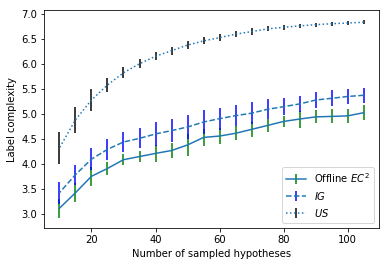

In [14]:
num_samples = list(sums_all_EC2.keys())
numtests_mean_EC2.reverse()
numtests_mean_IG.reverse()
numtests_mean_US.reverse()
numtests_std_EC2.reverse()
numtests_std_IG.reverse()
numtests_std_US.reverse()
num_samples.reverse()



plt.figure()
plt.errorbar(num_samples, numtests_mean_EC2, yerr=numtests_std_EC2, ecolor='g',linestyle='-', label=r"Offline $EC^2$")
plt.errorbar(num_samples, numtests_mean_IG, yerr=numtests_std_IG, ecolor='b',linestyle='--', label=r"$IG$")
plt.errorbar(num_samples, numtests_mean_US, yerr=numtests_std_US, ecolor='black',linestyle=':', label=r"$US$")
plt.xlabel('Number of sampled hypotheses')
plt.ylabel('Label complexity')
plt.legend()
plt.savefig('train_label_complexity_EC2_IG_US.eps', format='eps')


In [15]:
for k in utility_all_EC2.keys():
    utility_all_EC2[k] = [x[0] for x in utility_all_EC2[k]]
    utility_all_IG[k] = [x[0] for x in utility_all_IG[k]]
    utility_all_US[k] = [x[0] for x in utility_all_US[k]]
    

In [16]:



utility_mean_EC2 = [np.mean(np.array(x)) for x in utility_all_EC2.values()]
utility_mean_IG = [np.mean(np.array(x)) for x in utility_all_IG.values()]
utility_mean_US = [np.mean(np.array(x)) for x in utility_all_US.values()]


utility_std_EC2 = [np.std(np.array(x)) for x in utility_all_EC2.values()]
utility_std_IG = [np.std(np.array(x)) for x in utility_all_IG.values()]
utility_std_US = [np.std(np.array(x)) for x in utility_all_US.values()]

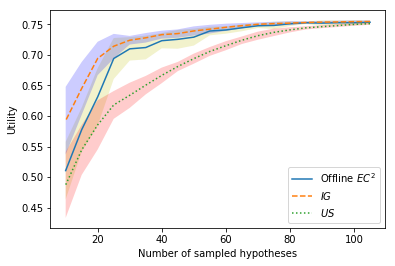

In [17]:
num_samples = list(utility_all_EC2.keys())
utility_mean_EC2.reverse()
utility_mean_IG.reverse()
utility_mean_US.reverse()
utility_std_EC2.reverse()
utility_std_IG.reverse()
utility_std_US.reverse()
num_samples.reverse()



plt.figure()
plt.plot(num_samples, utility_mean_EC2, linestyle='-', label=r"Offline $EC^2$")
plt.plot(num_samples, utility_mean_IG, linestyle='--', label=r"$IG$")
plt.plot(num_samples, utility_mean_US, linestyle=':', label=r"$US$")



plt.fill_between(num_samples, np.array(utility_mean_EC2)-np.array(utility_std_EC2), np.array(utility_mean_EC2)+np.array(utility_std_EC2), facecolor='y',alpha=0.2)
plt.fill_between(num_samples, np.array(utility_mean_IG)-np.array(utility_std_IG), np.array(utility_mean_IG)+np.array(utility_std_IG), facecolor='b',alpha=0.2)
plt.fill_between(num_samples, np.array(utility_mean_US)-np.array(utility_std_US), np.array(utility_mean_US)+np.array(utility_std_US), facecolor='r',alpha=0.2)


plt.xlabel('Number of sampled hypotheses')
plt.ylabel('Utility')
plt.legend()
# plt.gca().set_rasterized(True)
plt.savefig('train_Utility_EC2_IG_US.pdf', format='pdf')



In [18]:
utils_EC2 = []
numtests_EC2 = []
for u,n in zip(utility_mean_EC2, numtests_mean_EC2):
    utils_EC2.append(u)
    numtests_EC2.append(n)
    
    
utils_IG = []
numtests_IG = []
for u,n in zip(utility_mean_IG, numtests_mean_IG):
    utils_IG.append(u)
    numtests_IG.append(n)
    
utils_US = []
numtests_US = []
for u,n in zip(utility_mean_US, numtests_mean_US):
    utils_US.append(u)
    numtests_US.append(n)

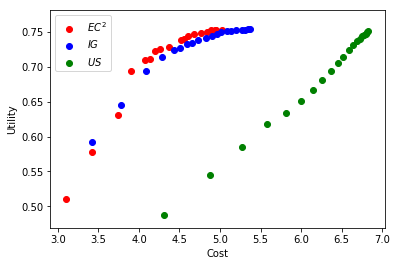

In [19]:
plt.figure()
plt.scatter(numtests_EC2, utils_EC2, color='r', label=r"$EC^2$")
plt.scatter(numtests_IG, utils_IG, color='b', label=r"$IG$")
plt.scatter(numtests_US, utils_US, color='g', label=r"$US$")
plt.legend()
plt.xlabel('Cost')
plt.ylabel('Utility')
plt.savefig('train_UtilityVSCost_EC2_IG_US.eps', format='eps')